# Random scores and sample losses
<details><summary>Initial focus: $\textbf{random constraint aware NN training}$ for binary classification</summary>
<ul>
    <li>
Work with randomly distributed feature and target data $(x,y)$ taking values in $\mathcal X\times\mathcal Y$
    </li><li>
        Want to be able to $\textbf{theoretically justify}$ a prediction $\hat y$ we make for $y$ in terms of how well it can be expected to minimise a dynamically fluctuating user defined notion of cost
    </li><li>
        To wit the statistics computed by a user can by modelled as $\textbf{random constraints}$ that are provided to a classifier immediately before it makes a prediction $\hat y$
 </li><li>
Focus on binary classification, where possible target values form a finite set $\#\mathcal Y=N_{\texttt{lab}}=2<\infty$ of two possible target label values.

</li><li>
Statistics about such models take at most two nonzero distinct values, so it is not immediately obvious how to go about finding functions that are amenable to gradient descent
</li><li>
-  Random setting means that objectives can be related in a natural way to continuous valued functions
</ul></details>
$\newcommand\dee{\mathrm{d}}
\newcommand\LBCE{\widetilde{\mathrm{BCE}}}
\newcommand\SBCE{\widehat{\textrm{BCE}}}
\newcommand\rs{\texttt{rs}}$

### Possible scores for a single prediction
<details>
    <summary>
Want to be able to theoretically justify a prediction $\hat y(x)$ made based on the feature for the target value $y$
    </summary>
<ul>
    <li>
Generally we allow predictions to depend on varying costs of misclassifications.
        </li><li>
To compute some statistic $c$ about a classification a user first has to fix some function of the possible prediction and outcomes $(\hat y,y)\in\mathcal Y^2$.
        </li><li>
    
For classification any such function can be represented by its values on the $N^2$ possible outcomes so that $c=C_s(\hat y,y)$ where $s$ is an RV taking values in a finite dimensional space of parameters $\Sigma$.
        </li><li>
Assuming a misclassification is always worse than a correct classification, we can rescale by, for example, subtracting any profits that would be gained from a correct prediction and restrict to an $N^2-N$ dimensional family of misclassification costs.
</li>
</ul>
</details>


- For binary classification up to a rescaling there are only two degrees of freedom for possible prediction-outcome pairs and the random statistic can be written
$$
c=C_\sigma(\hat y,y)
$$
where $\sigma_-=C_\sigma(+,-)$ and $\sigma_+=C_\sigma(-,+)$ are the costs of a false positive and false negative respectively
- For fixed sampled value of $\sigma$ can write down a Bayes rule in terms of the marginals
$$
y^*(x',\sigma)=\begin{cases}+\text{ if }\rho^*(x')=\frac{\mathbb P(+|x=x')}{\mathbb P(-|x=x')}>\frac{\sigma_-}{\sigma_+}=\kappa(\sigma),\\-\text{ otherwise}\end{cases}
$$
- This means that the optimal solution according to a probablistic formulation just checks whether the relative likelihood is greater than the cost ratio $\kappa=\tfrac{\sigma_-}{\sigma_+}$

### Theory and practice
<details><summary>A model trained by an NN isn't well calibrated, but it is easy to select an optimal cutoff, yielding a one parameter family of classifiers $(\hat y_t)_{t\in\mathbb R}$ that are increasingly conservative about predicting $y=+$
                                                                                                                                                                                                                                                </summary><ul><li>
In this case "increasingly conservative" means that $\hat y_{t'}\geq \hat y_{t}$ whenever $t'<t$
                                                                                                   </li><li>
We shall see that we can't naïvely treat the values returned by a model trained using BCE as probabilities
                                                                                                   </li><li>
This isn't an issue typically
                                                                                                   <ul><li>
Given a trained model $\tilde y$, it is straightforward to select a cutoff $\hat y_\kappa$ that minimises (training dataset sampled) expectations for a given cost ratio $\kappa$ - raw NN value ranges vary a great deal, as evidenced by output histograms
                                                                                                   </li><li>
A good regression model needn't return specific values - might be possible to force the optimall cutoff to be around zero
                                                                                                   </li><li>
Choosing a good cutoff is very easy though, so view taken here is that each trained model should be benchmarked with a sensible cutoff selection 
                                                                                                   </li><li>
Histograms are plotted here to demonstrate the variation in the actual values returned by trained models - if we fix a single threshold we automatically discard most algorithms that produce useable results
</ul>
Models considered here give good results - trying to ensure that a fixed cutoff for the output works well may be a good idea, but focus here on benchmarking novel models against existing approaches to which a reasonable user choice of cutoff has been applied
</li></ul></details>

# First experiments
- Cybersecurity dataset: $\verb|UNSW-NB15|$
- Features: $x\sim$ aggregated synthetic network traffic
- Class labels: $y\sim$ categorisation of traffic $x$ as benign or malicious... most rows are malicious, but further categorised accorting to the $\verb|lab_cat|$ column - individual attack categories used as targets in this work
- As provided, the test and train datasets seem differently distributed, dataset was concatenated, shuffled and split randomly to make new test and train sets
- Traditional rescale to make $\widehat{\mathbb E}(x_i|\texttt{Train})=0$ and $\widehat{\textrm{Var}}(x_i|\texttt{Train})=1$

In [1]:
from cal.dl import unsw
#data_unscaled=unsw(lab_cat=True,rescale=False)
data_rescaled=unsw(lab_cat=True,rescale=True)

- Depending on experimental procedure, need to split data etc, here: train-test split

In [2]:
(x_train,all_classes_train),(x_test,all_classes_test),(df_train,df_test),sc=data_rescaled


- First consider boring case where $\sigma$ is constant
- Rescaling $C$ by a constant doesn't change problem because all costs are transformed by the same constant, can parameterise by a single number, we make use of the cost ratio $\frac{\sigma_-}{\sigma_+}$ out of its simplicity and intuitiveness
- Can write expected cost for fixed feature $x=x'$ and prediction $\hat y=y'$ which we wish to minimise in expectation
$$
\mathbb E(C(y,y')|x=x')=\sigma_{-y'}\mathbb P(y=-y'|x=x')
$$

This has multiple classes, focus on the class label $\verb|lab_cat=='Generic'|$ for now:

In [3]:
y_train,y_test=all_classes_train=='Generic',all_classes_test=='Generic'
generic=dict(x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,
             cost_rats=[1,2,4,8,10,50,100],ds_name='unsw',plot_title='NN trained on UNSW')
print('P(Generic|train)=',y_train.mean())
print('P(Generic|test)=',y_test.mean())

P(Generic|train)= 0.2281269069983632
P(Generic|test)= 0.2292061409901375


### BCE
<details>
    <summary>Where does BCE come from?</summary>
    <list><li>
Write $(\Omega,\mathbb P,\sigma)$ for underlying random system
        </li><li>
Let $x$ and $y$ be RVs taking values in $\mathcal X$ and $\mathcal Y$, which we formally treat as maps from $\Omega$:
$$
\Omega\xrightarrow{x\times y}\mathcal X\times\mathcal Y
$$
        </li><li>
            Interested in dependence of $y$ upon $x$

        </li><li>
        Intuitively, if $y$ is in large part dependent upon the value of $x$, then there exists a model $\hat y(x)$ such that $\hat y\approx y$ in an appropriate sense

        </li><li>
If the user has access to everything is possible to represent $y$ as a random variable $z:\Omega\times\mathcal X\rightarrow\mathcal Y$ trivially by letting $z(\omega,x')=y(\omega)$, but we assume that they only have access to a factor $\Pi:\Omega\rightarrow\Omega'$ of $\Omega$ such that $x$ and $y$ are independent of $\Pi$.

        </li><li>
If we consider the RVs $u=(x,y)$ and $v=(x,z)$ representing a true system and an associated model their cross entropy is defined as
$$
H(u,v)=-\int_{\mathcal X\times\{\pm\}} f_u(x',y')\log(f_v(x',y'))\dee x'\dee y'
$$

        </li><li>

BCE minimisation: given sampled features $x_j\in\mathcal X$ for $j\in I$ with corresponding targets $y_i\in\{\pm\}$ write $\tilde y=f_z(x)$.

        </li><li>
Let $i$ be uniformly distributed in $I$, so that $x_i$ and $y_i$ are distributed empirically.
The sample cross entropy is the cross entropy of the RVs
$$
H((x_i,y_i),(x_i,z(x_i)))=\SBCE((f_z(x_i),y_I)=\SBCE((f_z(x_i),y_I)=-\frac1{\#I}\sum_{j\in I}1_{y_i=+}\log(f_z(x_i))+1_{y_i=-}\log(1-f_z(x_i))
$$
and used as basis for gradient descent etc.
</li>
</list>
</details>

### NN output interpreted as a log relative likelihood
<details><summary>If $\rho$ is interpreted as the log relative likelihood of some event then the sigmoid function $\sigma$ transforms $\rho$ into the corresponding probability $\tilde y=\sigma(\rho)$ of the event</summary>
     NN output can't be interpreted in this way but gives intuition on use of $\sigmoid$ for NN output
- Write
    $$
    \varphi(t)=-\log(\sigma(t))
    $$
- The BCE expressed in terms of the log likelihood then takes the form 
$$
\LBCE(\rho,y)=\SBCE(\sigma(\rho),y)=\begin{cases}\varphi(\rho)\text{ when }y=+\text{ and}\\\varphi(-\rho)\text{ otherwise}\end{cases}
$$
- Indeed this is the actual definition of $\texttt{sigmoid}\_\texttt{binary}\_\texttt{cross}\_\texttt{entropy}$ provided by optax.
</details>

### Loss asymptotics I: BCE
<details><summary>When binary cross entropy is applied to a quantity $\rho$ allowed to take values in the range of the log relative likelihood, the gradient of a very correct classification decays exponentially whereas the gradient of a very incorrect classification is constant</summary>
    <ul><li>
Want to check asymptotics at high and low uncertainty.
        </li><li>
By calculus $\varphi$ defined in the above section enjoys the properties
        </li><li>
$$
\varphi(t)\sim\begin{cases}e^{-t}\text{ for }t\gg0\text{ and}\\ t\text{ for }t\ll0\end{cases}
$$
        </li><li>
            If $y=0$ and $t\gg 0$ then
$$
\partial_z\SBCE(\sigma(t))=-\log(1-\sigma(t))\approx-\log(1-(1-e^{-t}))=-t
$$
and
$$
\partial_z\SBCE(\sigma(-t))=-\log(1-\sigma(-t))\approx-\log(1-e^{-t})\approx e^{-t}
$$
        </li><li>Symmetrically when $y=1$ we have
$$
\partial_t\SBCE(\sigma(t))\approx e^{-t}\text{ and }\partial_t\SBCE(\sigma(t))\approx t
$$

        </li><li>Size of gradient decays exponentially as $t$ moves in the direction of the correct prediction

        </li><li>Size of gradient is constant in direction of correct output for $t$ badly wrong
        </li>
</details>

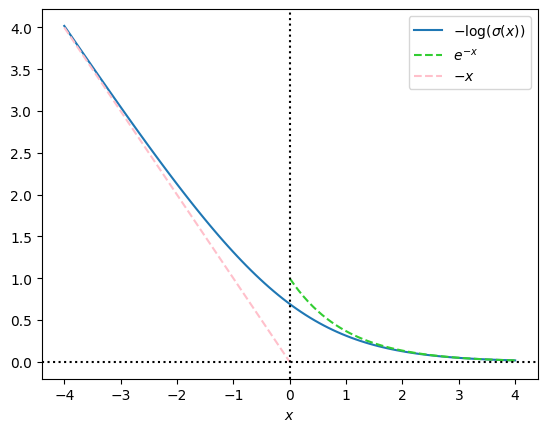

In [4]:
from matplotlib.pyplot import plot,show,legend,xlabel,ylabel,axvline,axhline,title

from jax.numpy import linspace,log,exp
def plot_asymptotics(f,f_lab,f_p,f_p_lab,f_n,f_n_lab,sh=True,
                     x=linspace(-4,4,100),xp=linspace(0,4,50),xn=linspace(-4,0,50)):
  plot(x,f(x),label=f_lab)
  plot(xp,f_p(xp),color='limegreen',linestyle='dashed',label=f_p_lab)

  plot(xn,f_n(xn),color='pink',linestyle='dashed',label=f_n_lab)
  xlabel('$x$')
  axvline(c='black',linestyle='dotted')
  axhline(c='black',linestyle='dotted')
  legend()
  if sh:
    show()

phi=lambda t:-log(1/(1+exp(-t)))
phi_p=lambda x:exp(-x)
phi_n=lambda x:-x

plot_asymptotics(phi,'$-\\log(\\sigma(x))$',phi_p,'$e^{-x}$',phi_n,'$-x$')

## Experiment 0
### Experiment 0.1: BCE on raw data
- Here we train with BCE and measure performance against a range of possible cost ratios
- Want to test effects of common resampling techniques

In [5]:
from cal.rs import resamplers_list

from cal.jal import NNPL

NO TRAINING!!! Just inspecting initial distribution of NN etc


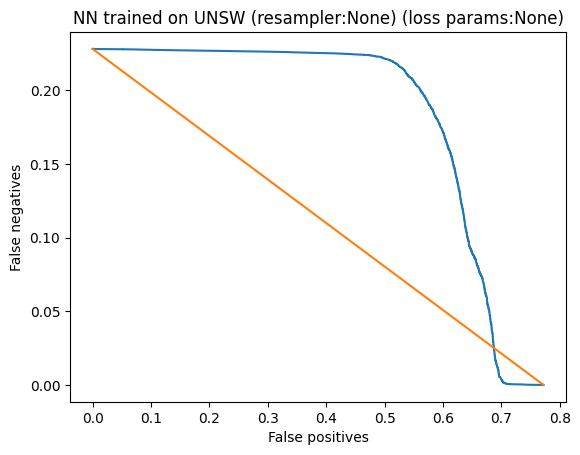

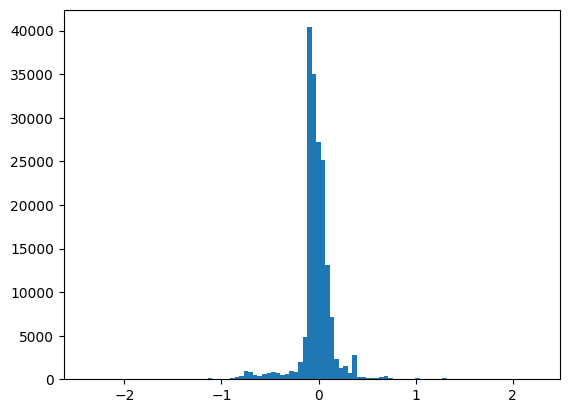

NO TRAINING!!! Just inspecting initial distribution of NN etc


In [6]:
nn_bce=NNPL(**generic)
print('NO TRAINING!!! Just inspecting initial distribution of NN etc')
nn_bce.mk_preds()
nn_bce.results()
nn_bce.plot()
print('NO TRAINING!!! Just inspecting initial distribution of NN etc')

Resampling took 0 seconds
Completed 100 epochs in 12.215526177998981 seconds
Getting fp-fn characteristic
cost_ratio   fp_train     fn_train     fp_test      fn_test      E(cost|test) resampler    loss param   
1            0.026622409  0.006878026  0.02100034   0.030911433  0.05191177                None         
2            0.02799117   0.0056347344 0.022384979  0.020806005  0.045252703               None         
4            0.028515862  0.005395201  0.023186611  0.015643978  0.04288126                None         
8            0.029781967  0.005081527  0.024121849  0.013287665  0.046111554               None         
10           0.029781967  0.005081527  0.024121849  0.013287665  0.049647283               None         
50           0.03712765   0.0046708984 0.03125152   0.008526454  0.064710766               None         
100          0.03712765   0.0046708984 0.03125152   0.008526454  0.088389695               None         


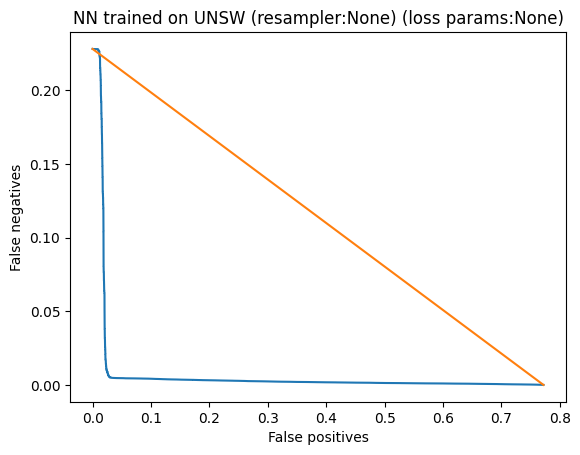

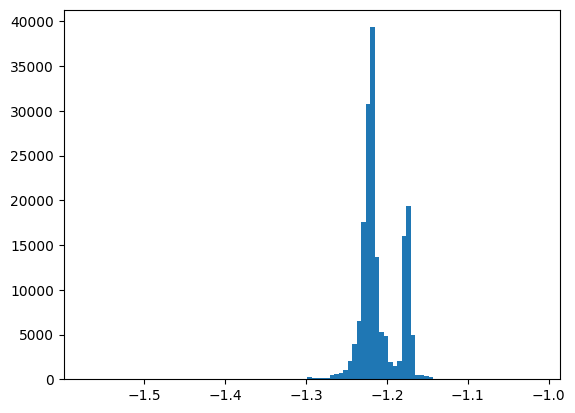

In [7]:
nn_bce.fit()
nn_bce.report()
nn_bce.plot()

- Not well calibrated (Bayes rule for threshold is useless) but not a problem really

### Experiment 0.2: Effects of resampling schemes on BCE
- Common to try using various resampling schemes during training
- Such a scheme takes dataset $D=(x^{(i)},y^{(i)})$ and transforms it to $D_\rs=(x_\rs^{(i)},y_\rs^{(i)})$
- Idea: address issues that arise from imbalance (note this framing is contentious in literature, with some taking a view that particularly hard problems described in this way may be better understood as a problem of limited data)

In [8]:
print(resamplers_list)

['NearMiss', 'SMOTEENN', 'ADASYN', 'SMOTE', 'SMOTETomek', '']


In [9]:
#nns={}
for rs in resamplers_list:
  #nn=NNPL(x_train,y_train,x_test,y_test,sigmoid_binary_cross_entropy,'unsw')
  nn_bce.fit(rs=rs)
  nn_bce.report(rs=rs)
  #nns[rs]=nn
nn_bce.report(topk=3)

Resampling data with method NearMiss ...
NearMiss doesn't take a random seed...
Resampling took 8.546675135999976 seconds
Completed 100 epochs in 6.584122248001222 seconds
Getting fp-fn characteristic
cost_ratio   fp_train     fn_train     fp_test      fn_test      E(cost|test) resampler    loss param   
1            0.03869032   0.006969277  0.030462032  0.03244182   0.06290385   NearMiss     None         
2            0.040133227  0.0060966914 0.03257543   0.02387893   0.056804214  NearMiss     None         
4            0.04073206   0.005874268  0.033292037  0.021644076  0.05993417   NearMiss     None         
8            0.041268155  0.005754501  0.034300152  0.020575233  0.07032248   NearMiss     None         
10           0.046458043  0.005224106  0.041150466  0.014903076  0.060140584  NearMiss     None         
50           0.064673975  0.004625273  0.06216295   0.009971822  0.0793026    NearMiss     None         
100          0.11376689   0.003935189  0.10634991   0.008125638 

In [10]:

### Experiment 0.2: Cost
#def mk_cost(cr):
#  def cost(pred,targ):
#    return cr*targ*sigmoid(-pred)+(1-targ)*sigmoid(pred)
#  return jit(cost)

#print('Training on cost...')
#for cr in cost_rats+[200,400]:
#  nn=NNPL(x_train,y_train,x_test,y_test,mk_cost(cr))
#  nn.epochs()
#  nn.report(cost_rats)
#  nn.plot('NN trained on UNSW with cost for ratio '+str(cr))

# General classifier losses as weighted sums of costs
- At a glance seems cost may be useless - but any loss of interest can be written as a sum of all possible costs



#### "Cost loss"?
- Probablistically BCE loss analogous to learning likelihoods over wide range - use cases include high uncertainty in future costs
- Fixing costs is in a sense at other extreme of possible approaches - all we care about is whether likelihoods are above a set threshold
- Costs $\sigma_\pm$ for false negatives and false positives have an associated loss with constant gradient with respect to $\tilde y$ for fixed $y'\in\{\pm\}$,
$$
C_\sigma(\tilde y,y)=\sigma_+1_{y=+}(1-\tilde y)+\sigma_-1_{y=-}\tilde y
$$
so that gradients in the direction of the correct label are scaled by some notion of importance of each class.
When reframed as a function of the density this becomes
$$
\widetilde C_\sigma(\rho,y)=\sigma_+1_{y=+}\sigma(-\rho)+\sigma_-1_{y=-}\sigma(\rho)
$$

## Expected misclassification cost 
In a random formulation eg per https://link.springer.com/article/10.1007/s10994-024-06634-8 we seek to minimise $c$ in expectation:
$$
\mathbb E(c)=\int_{\Sigma\times\mathcal X\times\mathcal Y} C_\sigma(y',\hat y_{\sigma'}(x'))\dee\mathbb P(\sigma',x',y')
$$
Try their losses - but might be the case that most important aspect of analysis is asymptotic behaviour of losses


### Beta losses
<details><summary>Motivation and definition of loss used in  https://link.springer.com/article/10.1007/s10994-024-06634-8</summary>
- Authors of above paper observe that if a prior distribution for $\sigma$ can be assumed, the above expectation expression is a natural objective
- They let positive and negative costs be gamma RVs with parameters $(\alpha,\theta)$ and and obtain an expected misclassification cost proportional to
\begin{align*}
L_{\alpha\beta}(\tilde y,y)=&\int_0^{\tilde y}(t-y)t^{\alpha-1}(1-t)^{\beta-1}\dee t\\
=&\begin{cases} -\int_0^{\tilde y}t^{\alpha-1}(1-t)^\beta\dee t\text{ if }y=+,\\
\int_0^{\tilde y}t^\alpha(1-t)^{\beta-1}\dee t\text{ otherwise}\end{cases}\\
=&B(\alpha+(1-y),\beta+y;\tilde y)\\
=&B(a,b,\tilde y)\text{ for convenience}
\end{align*}
- $B$ is well known - the (incomplete) beta function 
</details>

### Loss asymptotics II: Beta loss at high certainties
- $a$ and $b$ describe the asymptotic order of $B(a,b,t)$ for $t\approx0$ and $t\approx 1$ respectively
- Specifically can check that
$$
B(a,b,t)\sim\begin{cases}O\left(\begin{cases}t^a\text{ if }a>0\\\log(t)\text{ if }a=0\end{cases}\right)\text{ when }0\approx t\ll1,\\O\left(\begin{cases}(1-t)^b\text{ if }b>0\\\log(1-t)\text{ if }b=0\end{cases}\right)\text{ when }0\ll t\approx1\end{cases}
$$


- This behaviour is mirrored in the log likelihood picture, where
$$
\widetilde B(a,b,\rho)\sim\begin{cases}
O\left(\begin{cases}
e^{\rho a}\text{ if }a>0\\
\rho\text{ if }a=0
\end{cases}\right)\text{ when }\rho\ll0,\\
O\left(\begin{cases}
e^{-\rho b}\text{ if }b>0\\
-\rho\text{ if }b=0
\end{cases}\right)\text{ when }\rho\gg0
\end{cases}
$$

- which means that
$$
\widetilde L_{\alpha\beta}(\rho,+)=\tilde B(\alpha,\beta+1;\rho)\sim
\begin{cases}
O(-e^{\rho\alpha})\text{ if }\alpha>0,~y=+\text{ and }\rho\ll0\\
O(-\rho)\text{ if }\alpha=0,~y=+\text{ and }\rho\ll0\\
O(e^{\rho(\beta+1)})\text{ if }~y=+\text{ and }\rho\gg0\\
\end{cases}
$$

- The parameters $\alpha$ and $\beta$ are not directly related to any single value of cost and should be taken to describe the tail risk associated with each type of error
- This is in line with the consequences of different decisions eg in the case of cybersecurity - legitimate traffic on a network being blocked may cause serious problems in the short term, but doesn't typically have the risks associated with malicious actors being able to access a network.

### Loss asymptotics III: Beta loss for small $\alpha$ and $\beta$ as perturbations of BCE
- From above discussion view $\alpha$ and $\beta$ as controlling the cost uncertainty for false negative and false positive
- Need each of $a$ and $b$ in the above expression to be nonnegative, whence it is necessary that $(\alpha,\beta)\in[0,\infty)^2$
- Can check by substitution that $B(a,b;c)=B(b,a,1-c)$ and $B(-1,0;\tilde y)=\log\tilde y$
- It follows that $L_{00}=\SBCE$
- If $\alpha$ and $\beta$ are small this is a parameterised perturbation of the BCE - in order for the loss to be well defined both $\alpha$ and $\beta$ must be nonnegative so the BCE can be seen is a limit as uncertainty in the positive and negative costs diverges
- Initially fix $\alpha$ and try small values of $\beta$ - this corresponds to assuming increasingly thin tails on the uncertainty in the cost of a false positive

### Numerical instability for provided beta functions
- Naively trying out this map doesn't go well
- doesn't seem particularly numerically stable over range of interest, so this is unsurprising
- Could just write down a desired gradient directly or choose another perturbation of BCE in the direction of higher cost certainty - we will do the latter

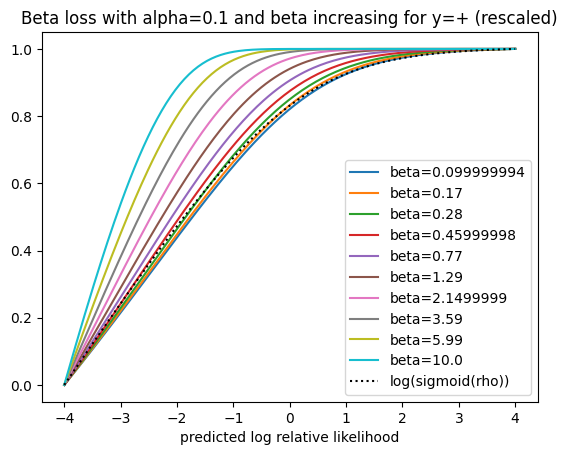

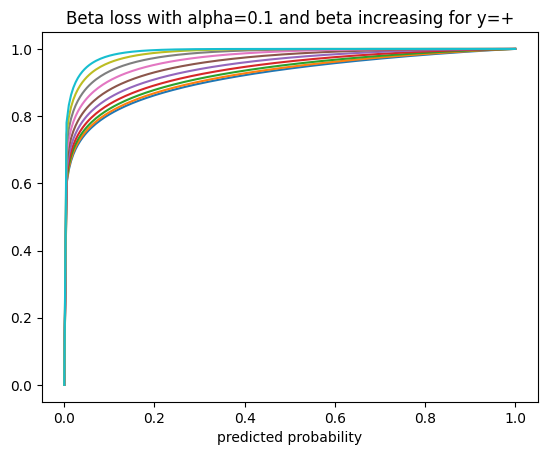

In [11]:
# For now, just use $\alpha=10^{-1}$ and scale $\beta$ - should investigate numerical stability further though...
from jax.scipy.special import betainc
from jax.scipy.stats.beta import cdf
from jax.numpy import geomspace
from jax.nn import sigmoid
Ir=linspace(-4,4,200)
betas=geomspace(.1,10,10)
alpha_small=.1
for b in betas:
  
  l=cdf(sigmoid(Ir),alpha_small,b+1)
  l/=(l.max()-l.min())
  l-=l.min()
  plot(Ir,l,label='beta='+str(round(100*b)/100))
l=log(sigmoid(Ir))
l/=(l.max()-l.min())
l-=l.min()
plot(Ir,l,label='log(sigmoid(rho))',c='black',linestyle='dotted')
xlabel('predicted log relative likelihood')
title('Beta loss with alpha='+str(alpha_small)+' and beta increasing for y=+ (rescaled)')
legend()
show()

Ip=linspace(0,1,200)
for b in betas:
  l=cdf(Ip,alpha_small,b+1)
  plot(Ip,l,label='beta='+str(round(100*b)/100))

title('Beta loss with alpha='+str(alpha_small)+' and beta increasing for y=+')

xlabel('predicted probability')
show()

def mk_fp_relaxed_beta_loss(beta,alpha_small=alpha_small):
  def beta_loss(pred,targ):
    return betainc(alpha_small+1-targ,beta+targ,sigmoid(pred))
  
  return jit(beta_loss)
    

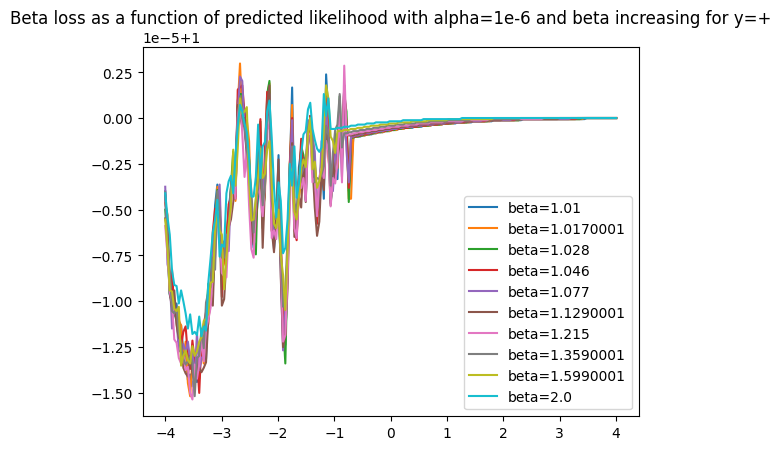

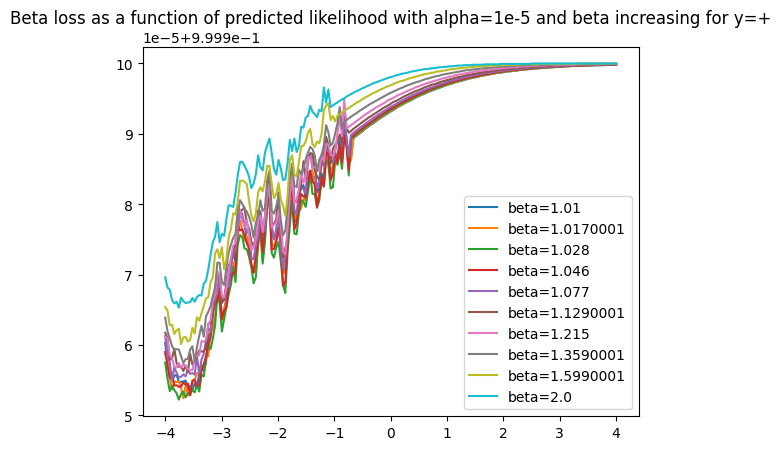

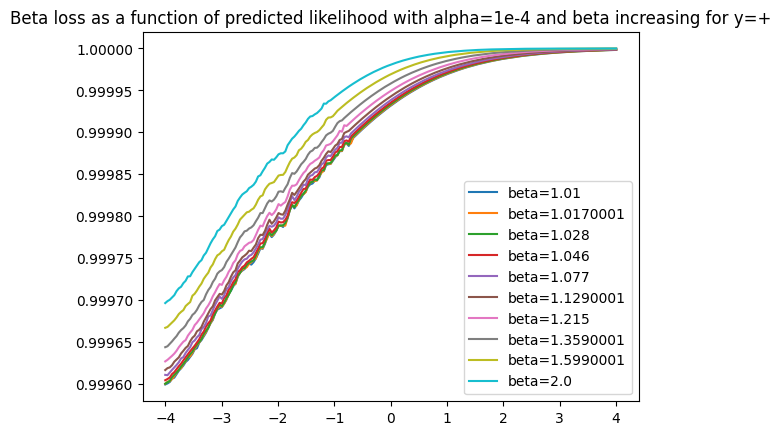

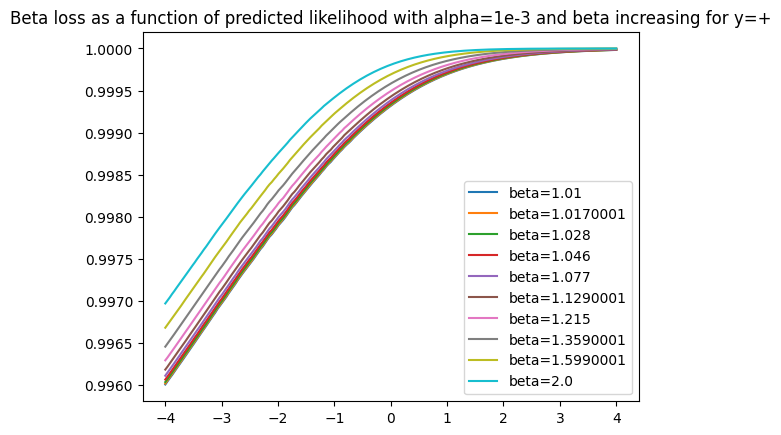

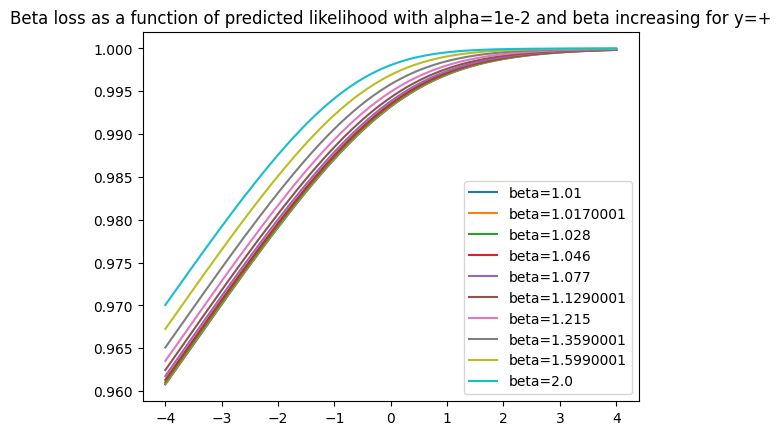

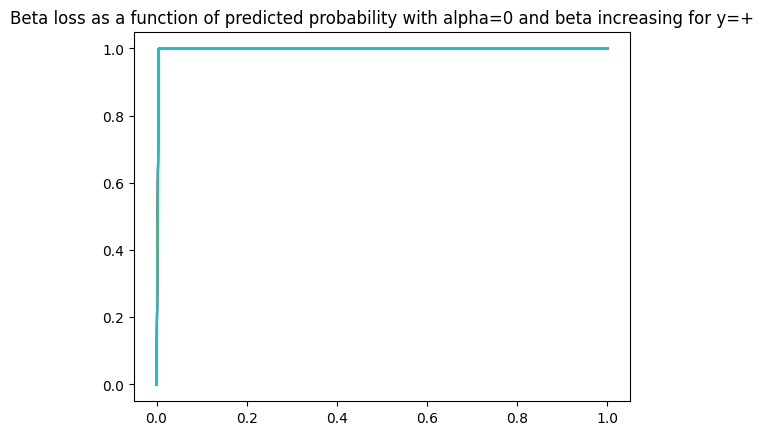

In [12]:

Ir=linspace(-4,4,200)
betas=1.+geomspace(.01,1,10)
for a in [1e-6,1e-5,1e-4,1e-3,1e-2]:
  for b in betas:
    plot(Ir,betainc(a,b,sigmoid(Ir)),label='beta='+str(round(1000*b)/1000))
  title('Beta loss as a function of predicted likelihood with alpha=1e'+str(round(log(a)/log(10)))+\
        ' and beta increasing for y=+')
  legend()
  show()

Ip=linspace(0,1,200)
for b in betas:
  plot(Ip,betainc(0,b,Ip))
title('Beta loss as a function of predicted probability with alpha=0 and beta increasing for y=+')
show()


- Still seems pretty bad - and get nans upon training


In [13]:
nn_beta=NNPL(loss=mk_fp_relaxed_beta_loss,**generic)
betas=[0,1e-5,1e-4,1e-3,1e-2,1e-1,1.,10.]
#for beta in geomspace(beta_large,beta_small,10):
#  nn_beta.fit(loss_param=float(beta))
#  nn_beta.report(loss_param=float(beta))
#  nn_beta.plot(loss_param=float(beta))

### Loss asymptotics III: a simple surrogate
- The core of the idea behind the loss proposed by https://link.springer.com/article/10.1007/s10994-024-06634-8 is that different loss choices relate to different cost uncertainties - higher $\alpha$ and $\beta$ values correspond to thinner tails on cost
- as an alternative with similar asymptotic behaviour, we modify binary cross entropy by exponentiating $\sigma(\rho)$ rather than taking logarithms when $y$ is $\boldsymbol -$, which corresponds to lower tail risk associated with false positives
$$
L_{\theta}(\rho,y)=\begin{cases}-\log(\sigma(\rho))\text{ if }y=\boldsymbol+,\\\theta^{-1}(\sigma(\rho))^\theta\text{ otherwise}\end{cases}
$$

In [14]:
from cal.jal import make_fp_perturbed_bce

## $\beta$-perturbed BCE

In [15]:
nn_g=NNPL(loss=make_fp_perturbed_bce,**generic)

for beta in betas:
  nn_g.fit(loss_param=float(beta))

nn_g.report(rs_vs_raw=True,topk=3)#,plot_res=True)

Resampling took 0 seconds
Completed 100 epochs in 11.346210407995386 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.46835806099989 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.613250032998621 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.562246260997199 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.479610669994145 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.47893390700483 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.478218846998061 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.548514670001168 seconds
Getting fp-fn characteristic
cost_ratio   fp_train     fn_train     fp_test      fn_test      E(cost|test) resampler    loss param   

===================== cost(fn)/cost(fp)= 1 =====

### $\beta$-perturbed BCE+resampling

In [16]:
print(resamplers_list,betas)

['NearMiss', 'SMOTEENN', 'ADASYN', 'SMOTE', 'SMOTETomek', ''] [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]


In [17]:
for beta in betas:
  for rs in resamplers_list:
    nn_g.fit(loss_param=float(beta),rs=rs)

Resampling data with method NearMiss ...
NearMiss doesn't take a random seed...
Resampling took 8.488105909003934 seconds
Completed 100 epochs in 5.929497413002537 seconds
Getting fp-fn characteristic
Resampling data with method SMOTEENN ...
Resampling took 112.26714504200208 seconds
Completed 100 epochs in 18.546491443994455 seconds
Getting fp-fn characteristic
Resampling data with method ADASYN ...
Resampling took 12.664976856001886 seconds
Completed 100 epochs in 18.73663409200526 seconds
Getting fp-fn characteristic
Resampling data with method SMOTE ...
Resampling took 2.6134321259960416 seconds
Completed 100 epochs in 18.89358420300414 seconds
Getting fp-fn characteristic
Resampling data with method SMOTETomek ...
Resampling took 112.65602655400289 seconds
Completed 100 epochs in 18.705724318999273 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 10.883091634001175 seconds
Getting fp-fn characteristic
Resampling took 8.488105909003934 seconds


In [18]:
nn_g.report(topk=3)

cost_ratio   fp_train     fn_train     fp_test      fn_test      E(cost|test) resampler    loss param   
1            7.4141244e-050.005081527  8.5021624e-050.008720789  0.0088058105 SMOTETomek   0.0          
1            0.000131172970.0051157456 0.000121459460.008854395  0.008975854  SMOTEENN     0.0          
1            0.000256642760.005064417  0.000133605410.009085168  0.009218774  SMOTE        0.0          
2            0.000108360280.005058714  0.000121459460.008708644  0.012401766  SMOTETomek   0.0          
2            0.000131172970.0051157456 0.000121459460.008854395  0.012607889  SMOTEENN     0.0          
2            0.000262345940.005058714  0.000133605410.00904873   0.01289131   SMOTE        0.0          
4            0.000108360280.005058714  0.000121459460.008708644  0.017478017  SMOTETomek   0.0          
4            0.0002737523 0.005053011  0.000194335140.008708644  0.017514454  SMOTEENN     0.0          
4            0.000262345940.005058714  0.000133605410.0

- Very, very roughly, does correspond to larger values of $\beta$ leading to better behaviour subject to false negatives costing far more than false positives
- When $\beta$ is $0.1$ or so seems not far off resampling

In [19]:
nn_g.report(rs_vs_raw=True,topk=3)#,plot_res=True)

cost_ratio   fp_train     fn_train     fp_test      fn_test      E(cost|test) resampler    loss param   

===================== cost(fn)/cost(fp)= 1 =====================
1            7.4141244e-050.005081527  8.5021624e-050.008720789  0.0088058105 SMOTETomek   0.0          
1            0.000131172970.0051157456 0.000121459460.008854395  0.008975854  SMOTEENN     0.0          
1            0.000256642760.005064417  0.000133605410.009085168  0.009218774  SMOTE        0.0          
1            0.0029143211 0.0053381696 0.0023441676 0.010579119  0.012923287               0.01         
1            0.0016653264 0.005418014  0.0026599623 0.011672255  0.014332217               0.001        
1            0.0024979895 0.0057259854 0.0024899188 0.012024486  0.014514405               0.0001       

===================== cost(fn)/cost(fp)= 2 =====================
2            0.000108360280.005058714  0.000121459460.008708644  0.012401766  SMOTETomek   0.0          
2            0.000131172970.

Resampling took 0 seconds
Completed 100 epochs in 11.209059992004768 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.489729517001251 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.460771892001503 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.45935175199702 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.47946783000225 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.495159631005663 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.483226371994533 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.477329599998484 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.457359528001689 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs i

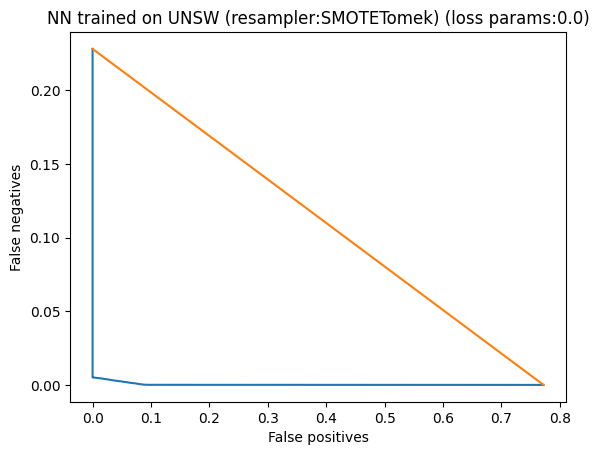

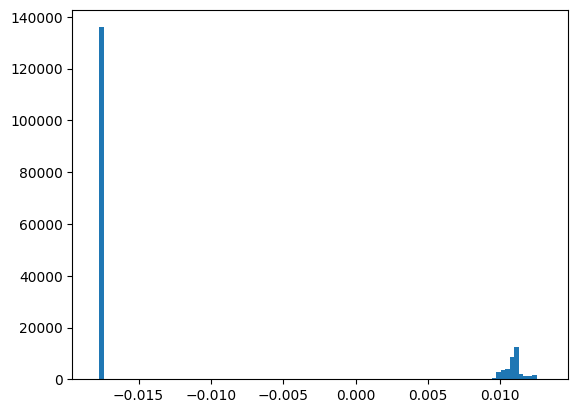

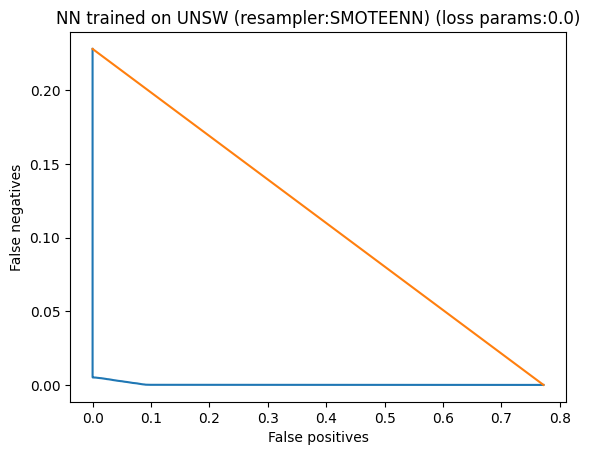

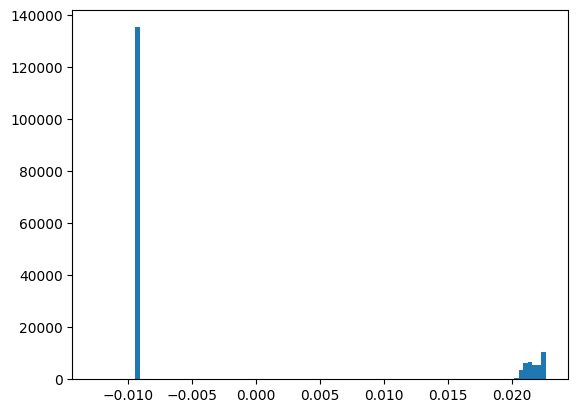

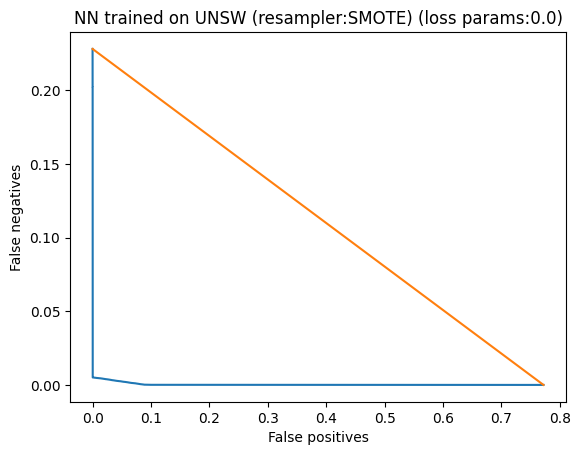

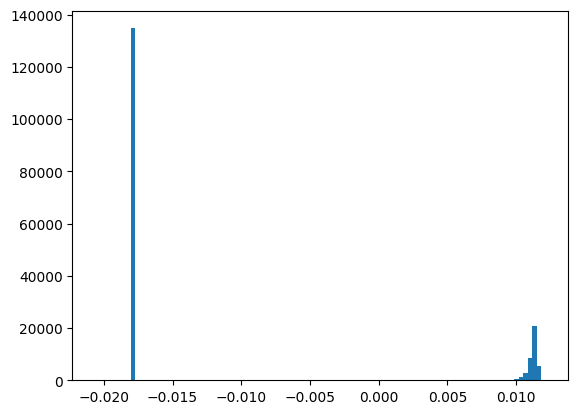

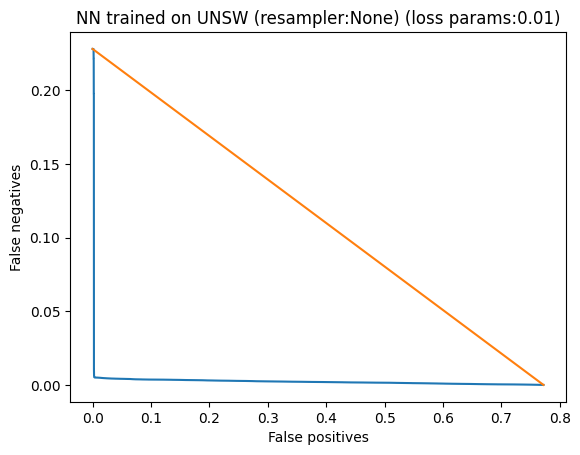

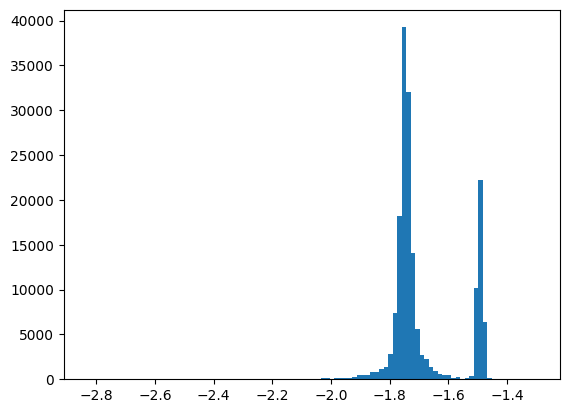

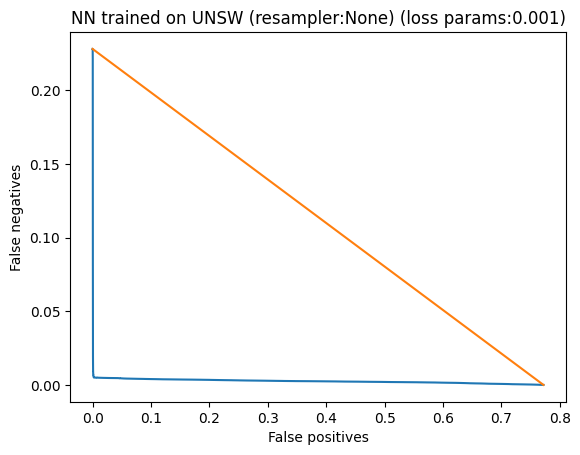

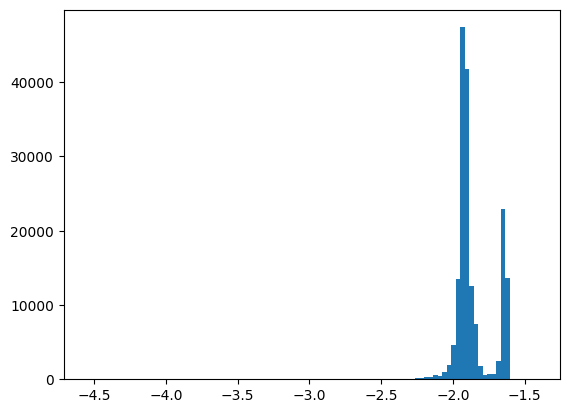

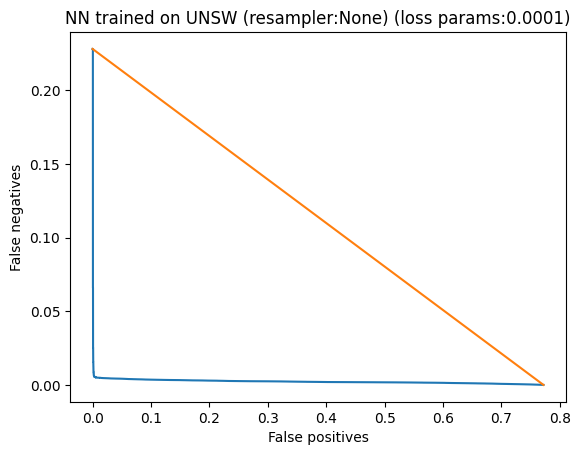

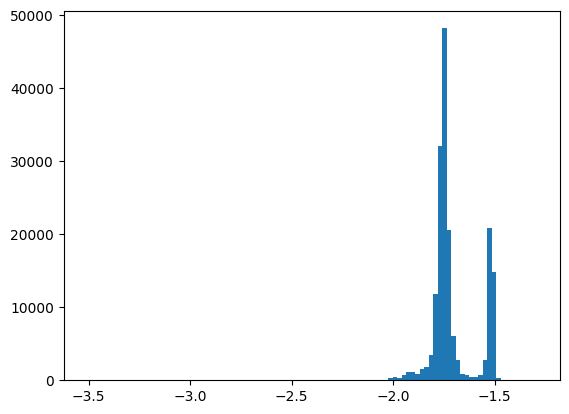

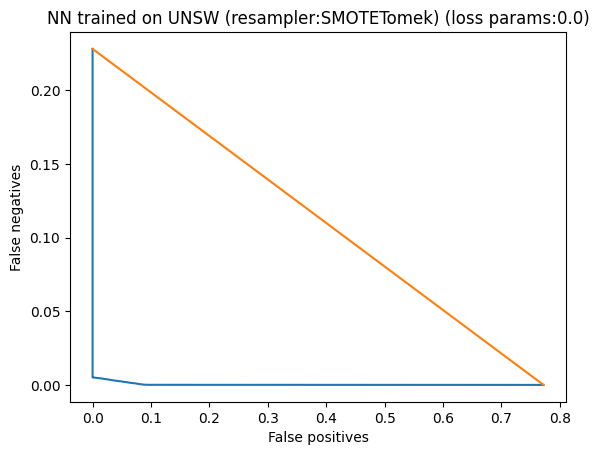

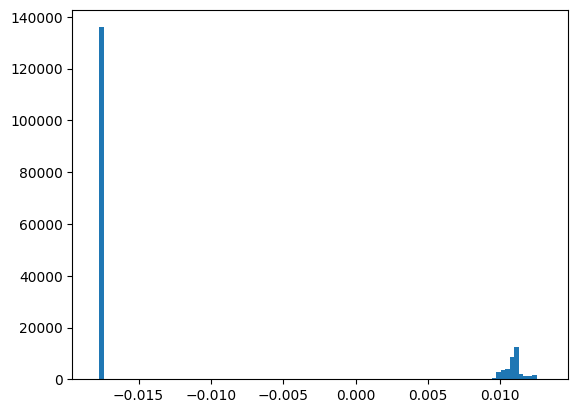

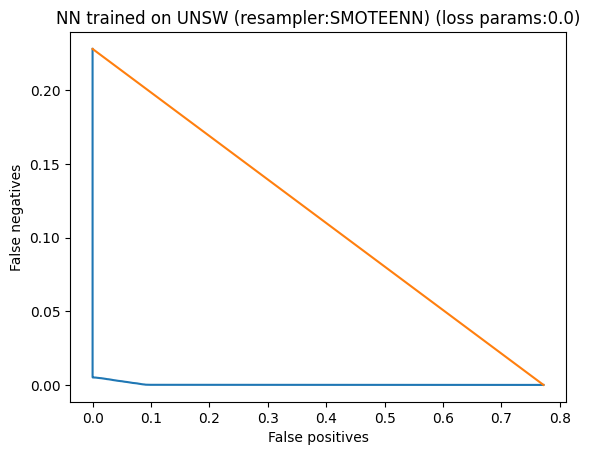

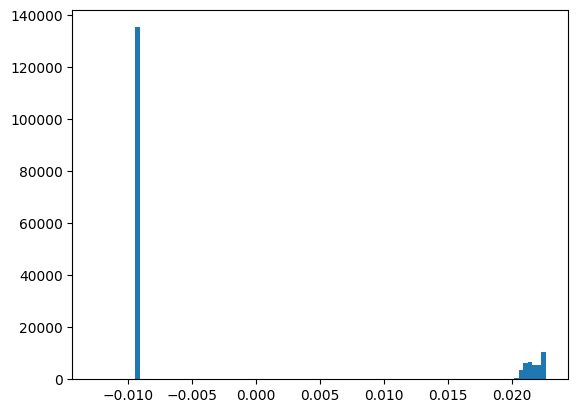

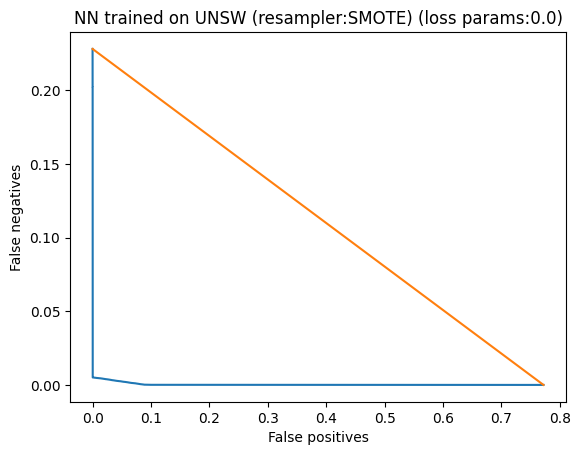

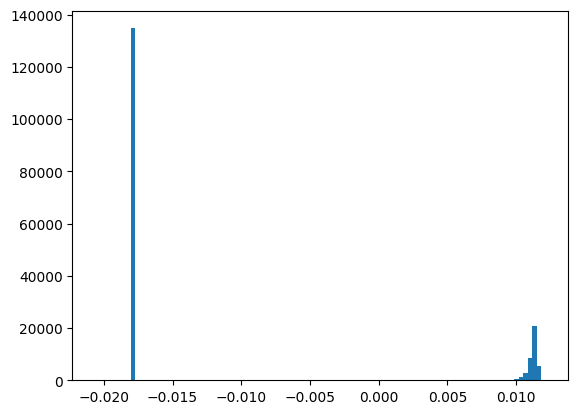

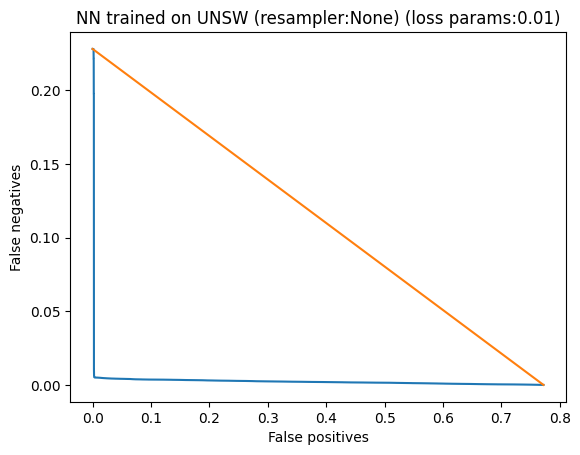

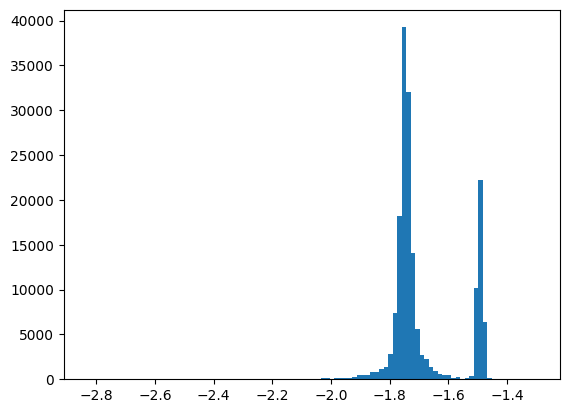

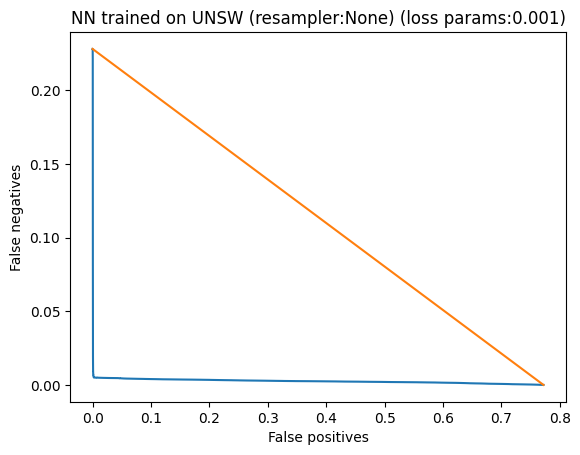

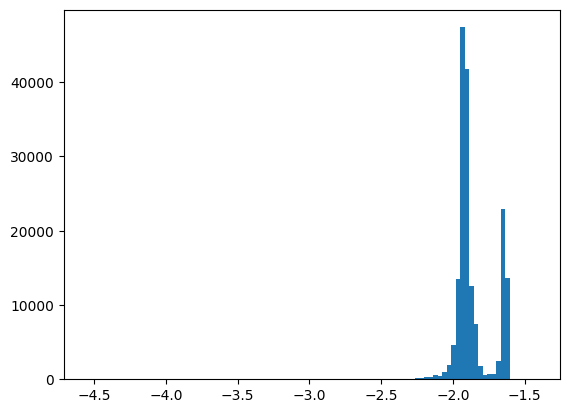

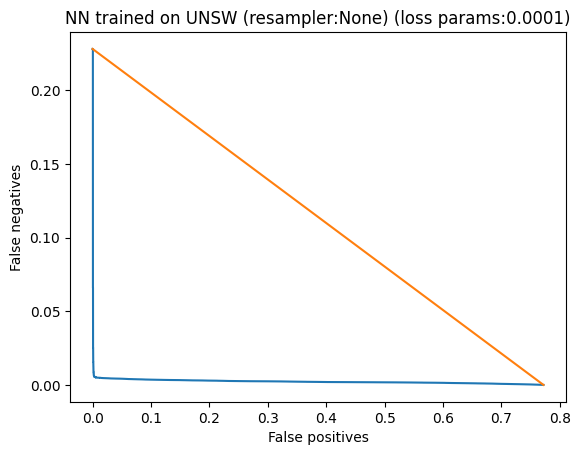

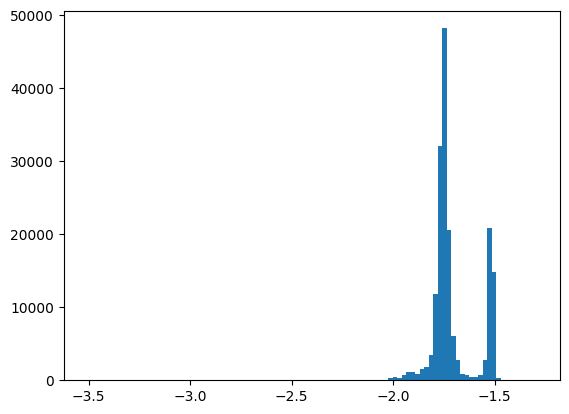

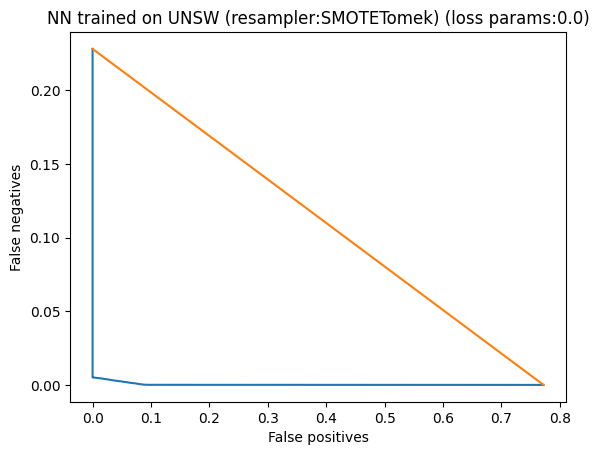

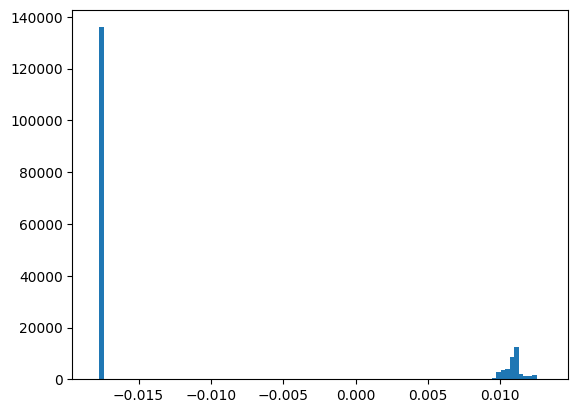

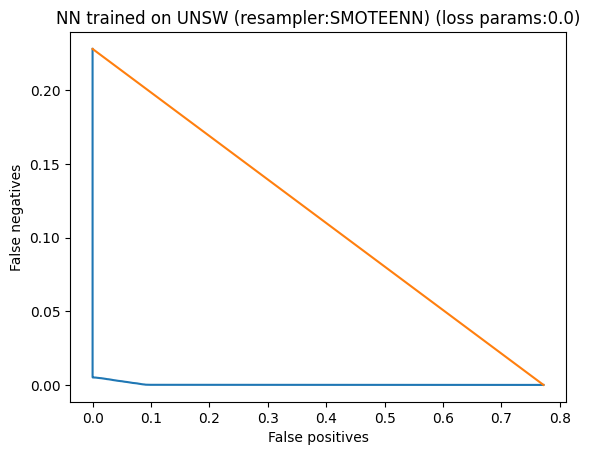

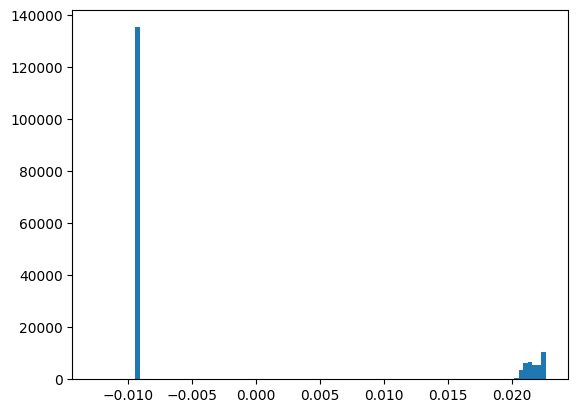

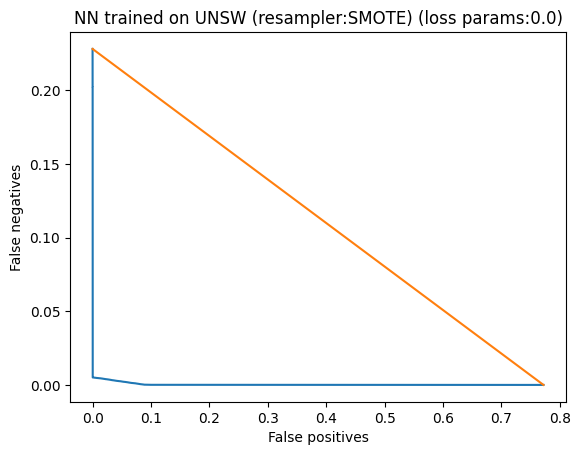

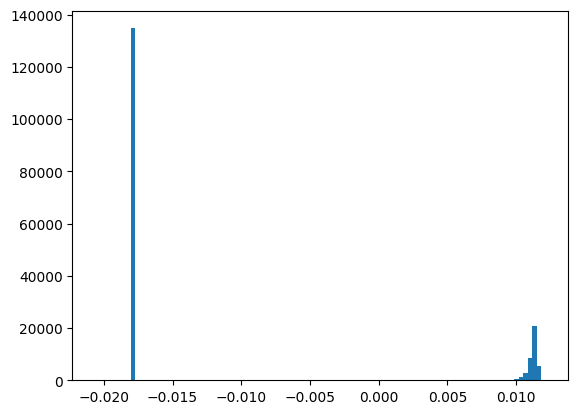

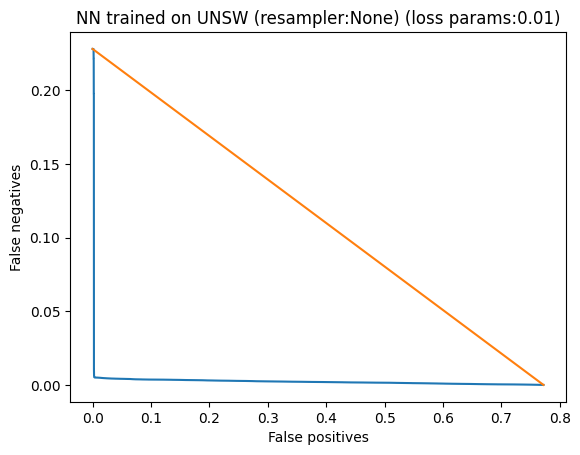

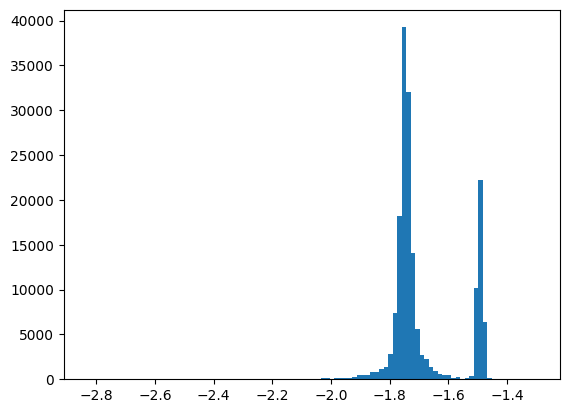

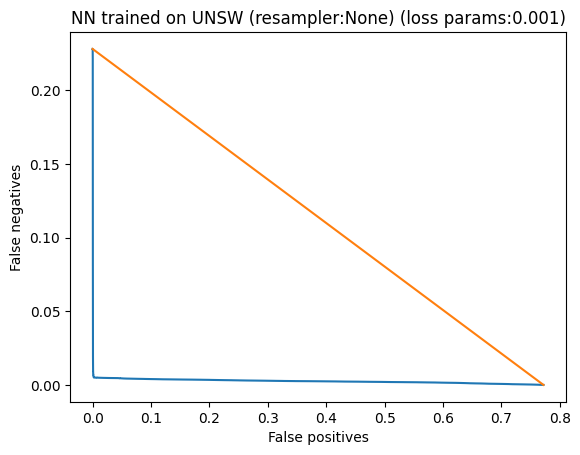

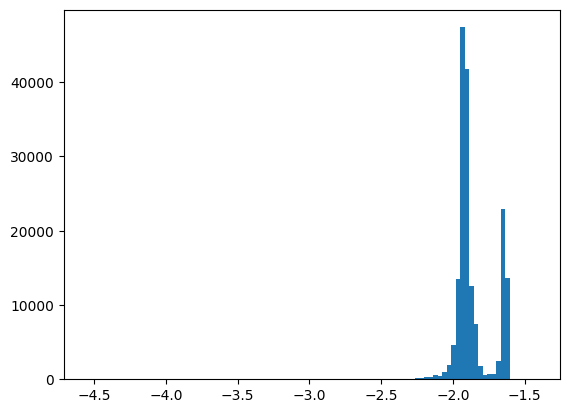

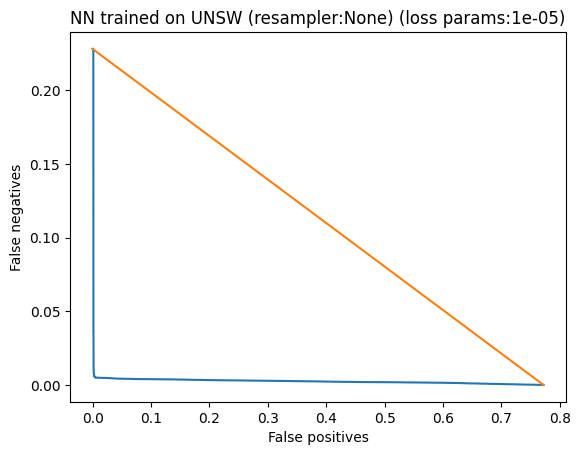

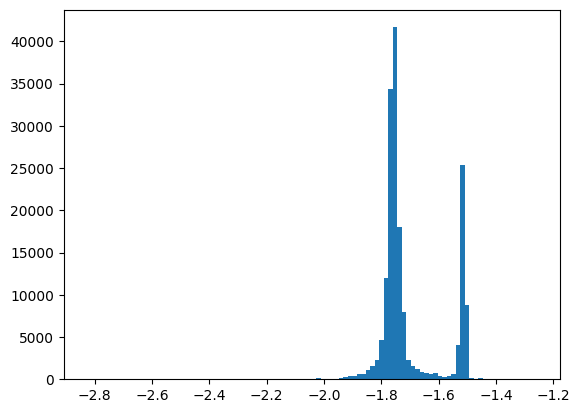

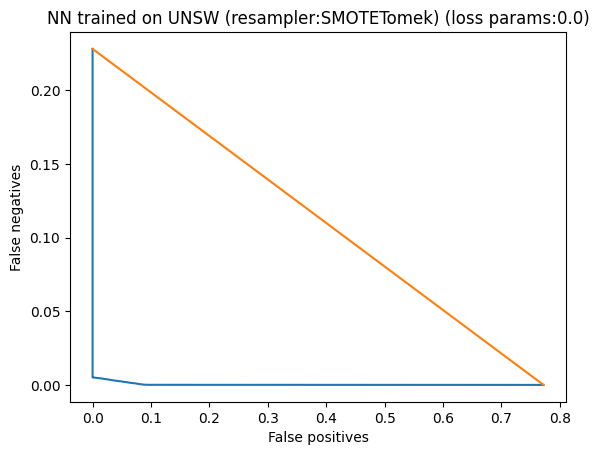

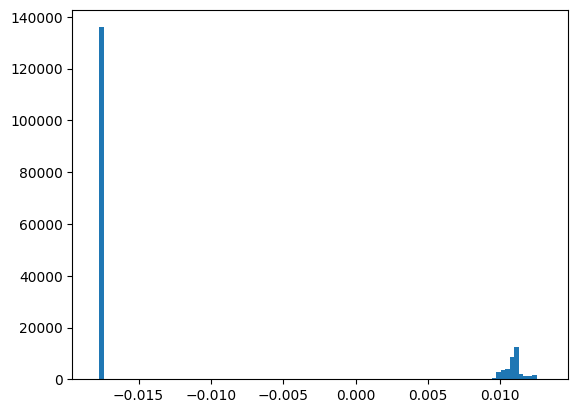

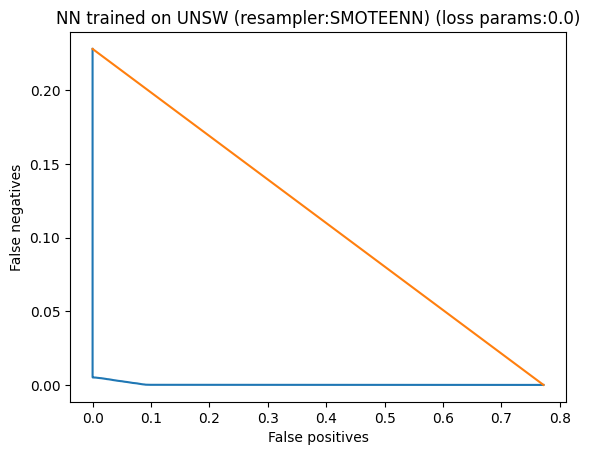

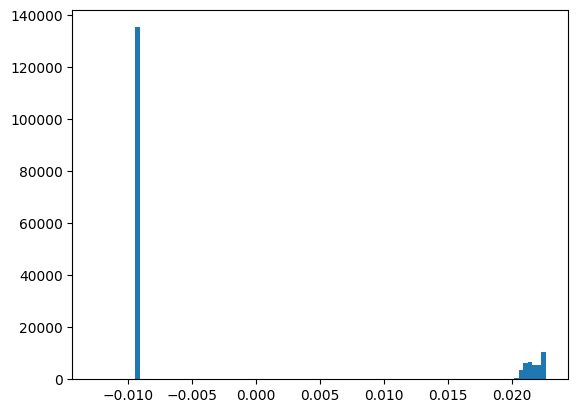

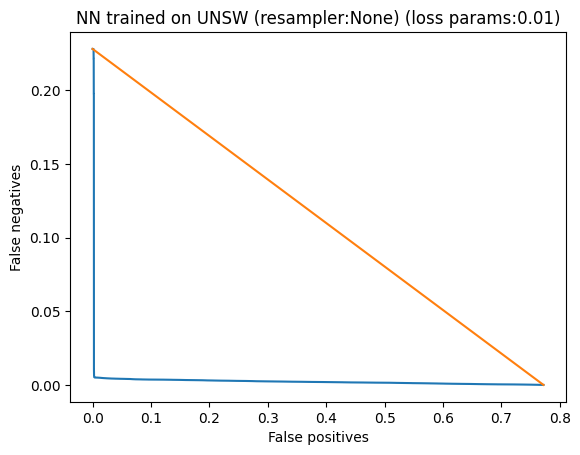

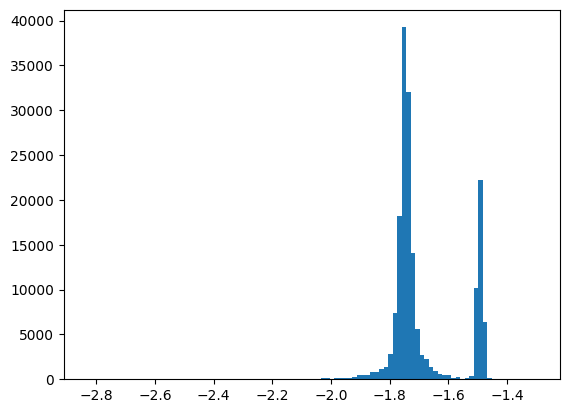

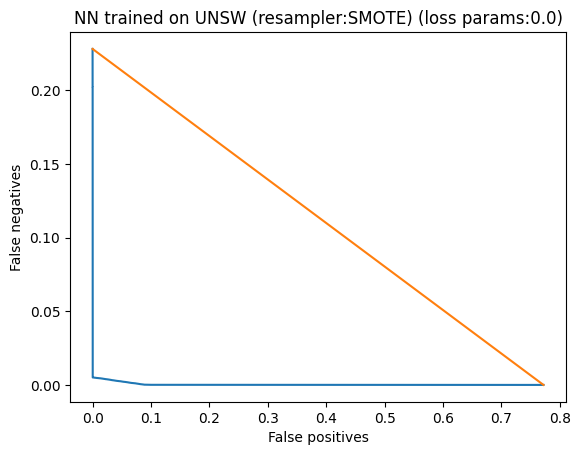

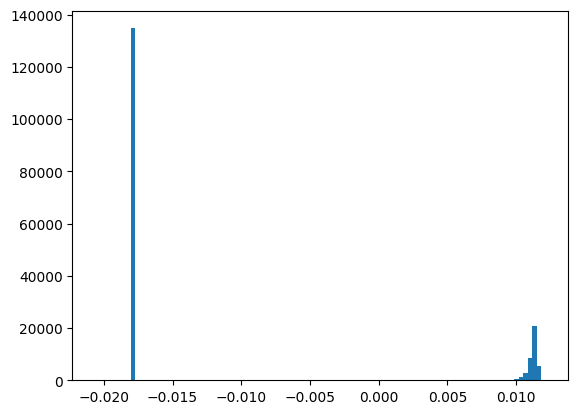

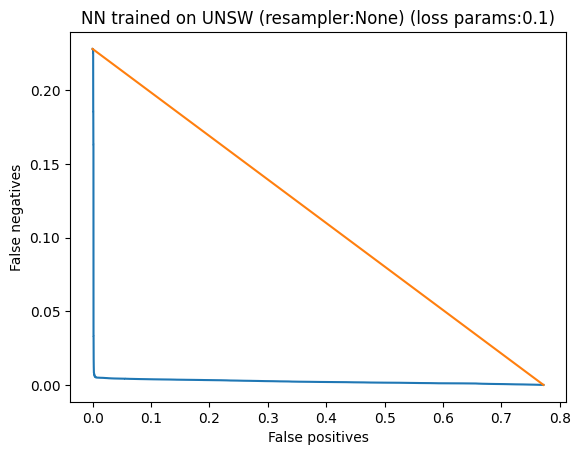

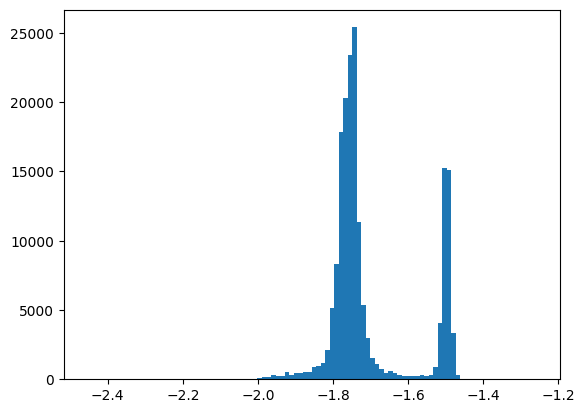

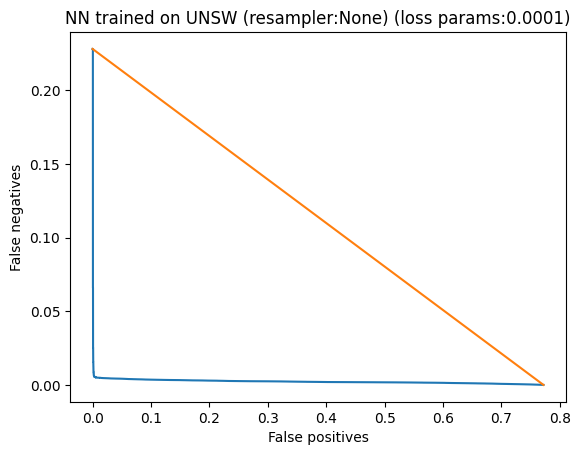

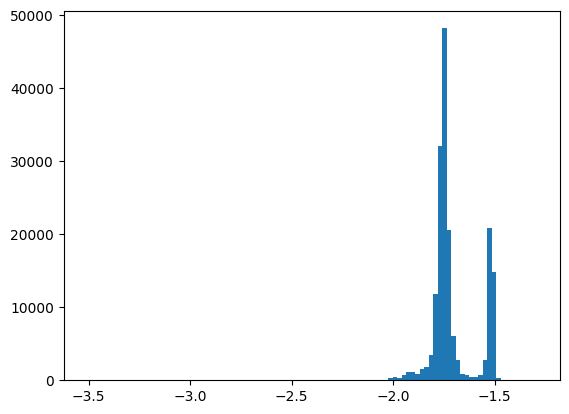

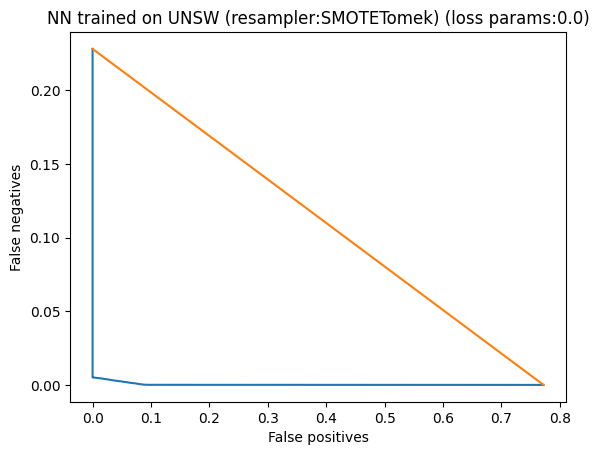

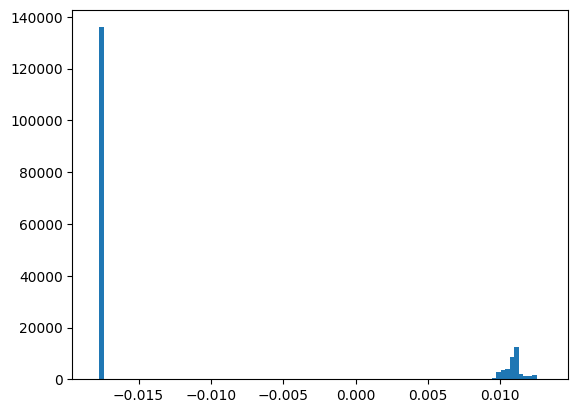

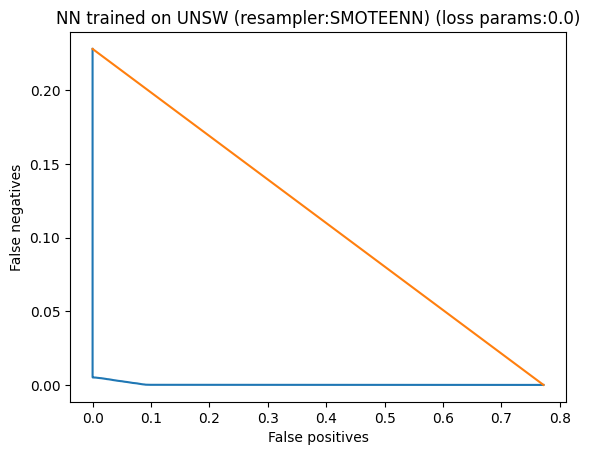

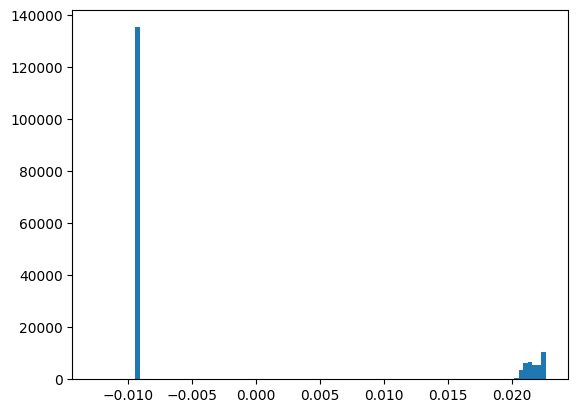

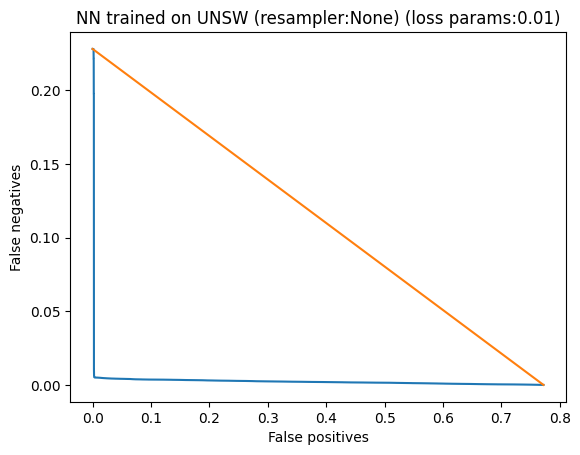

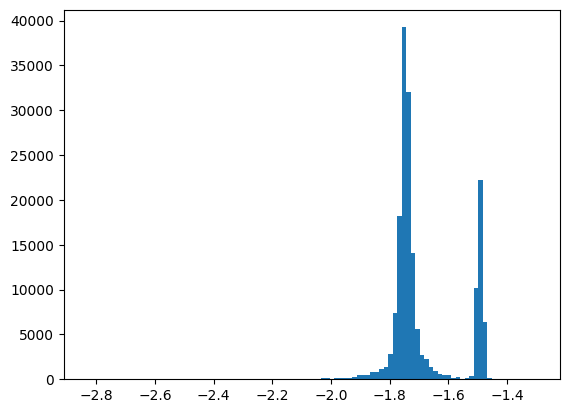

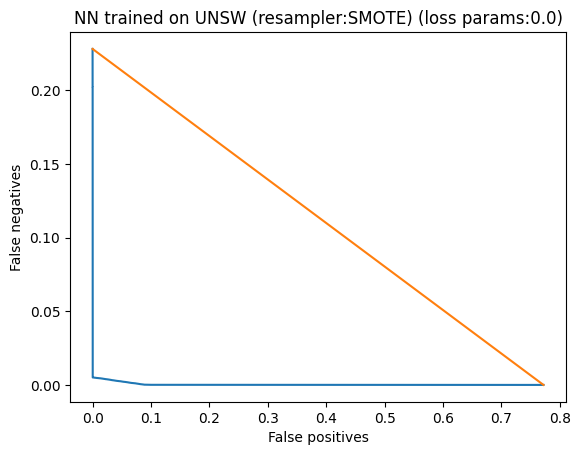

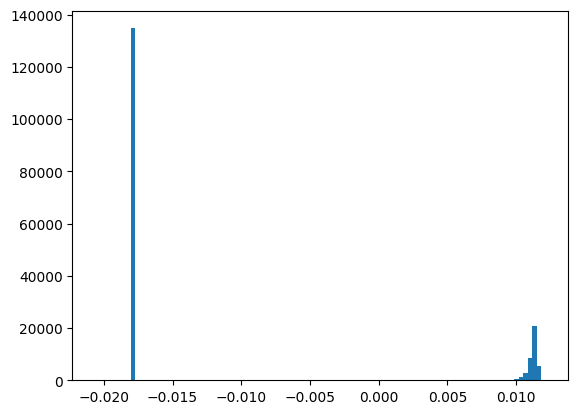

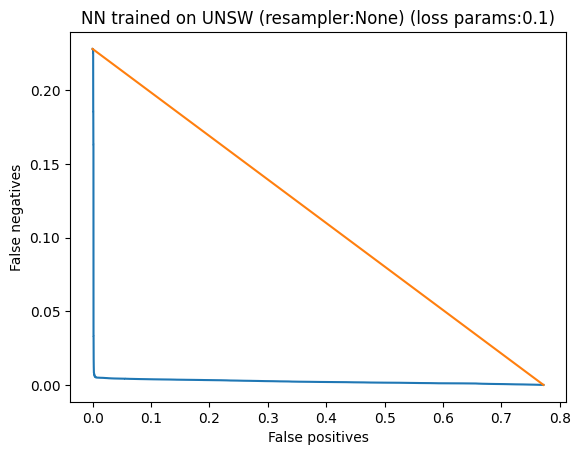

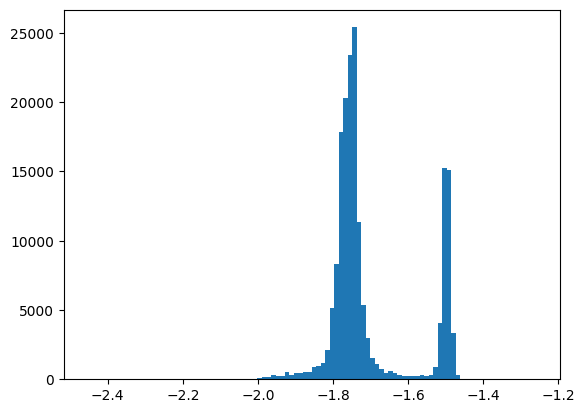

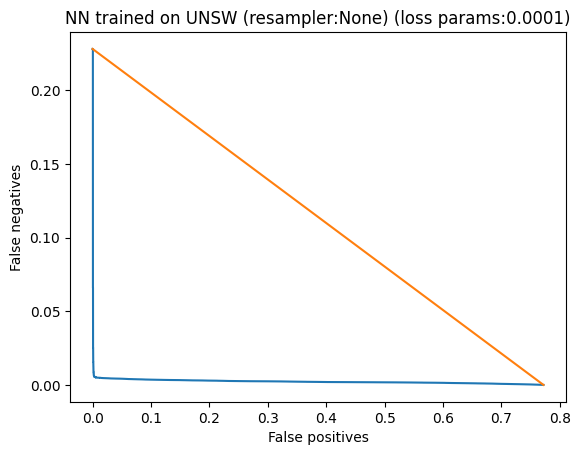

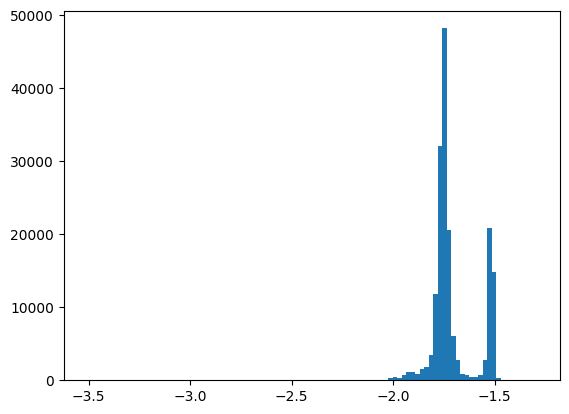

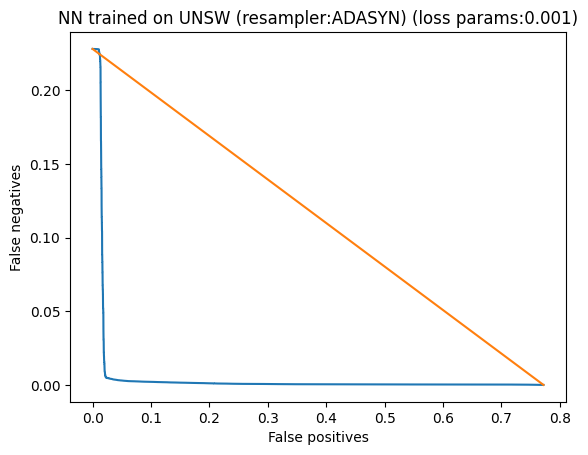

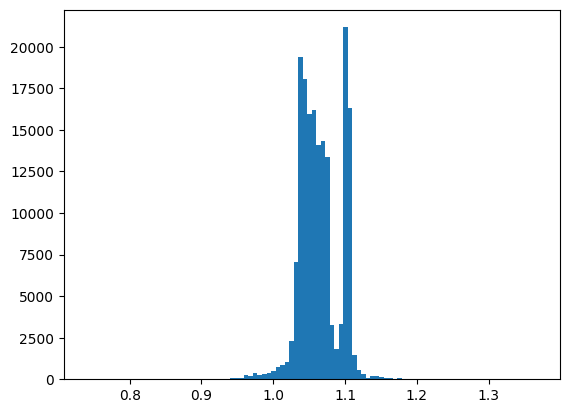

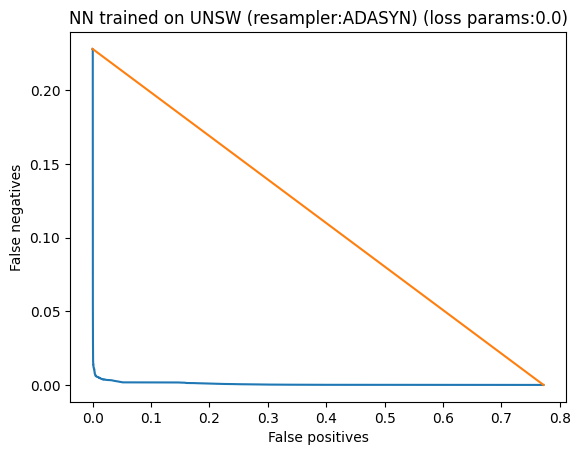

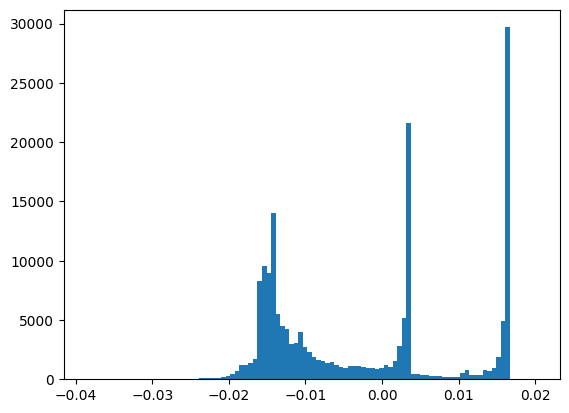

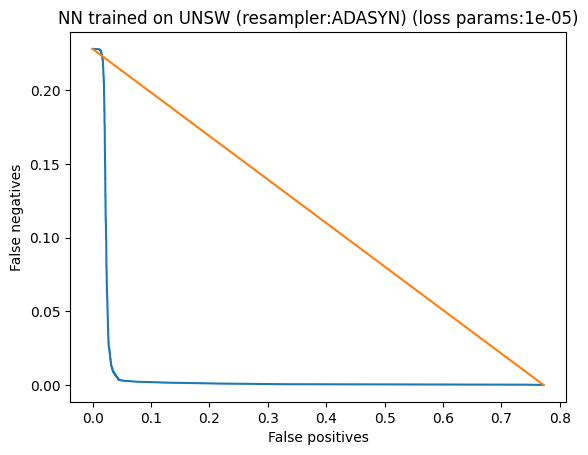

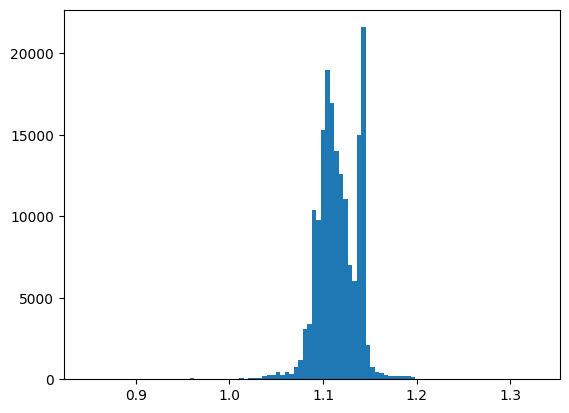

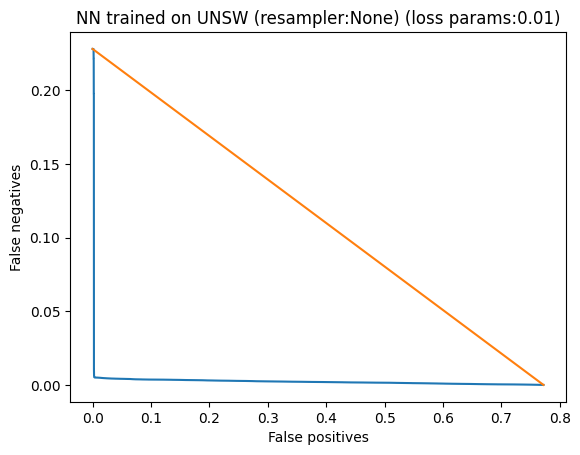

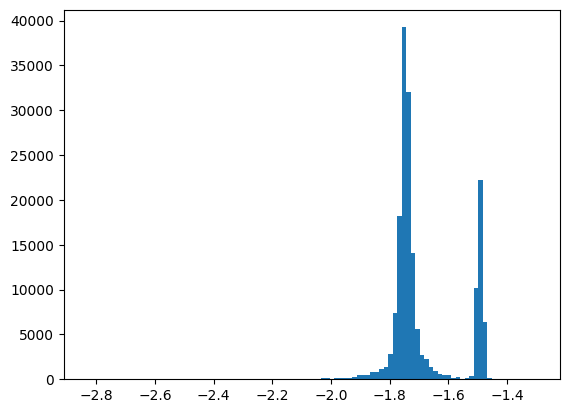

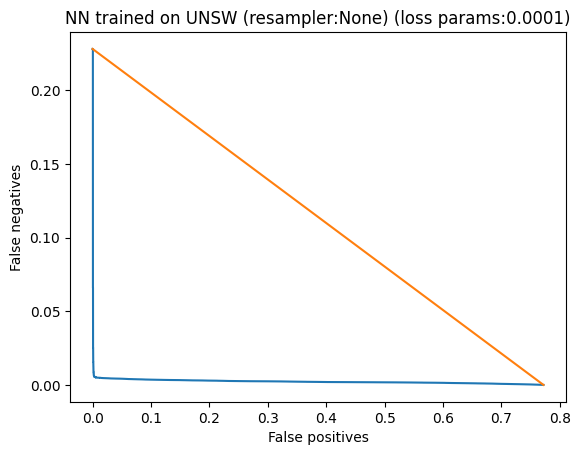

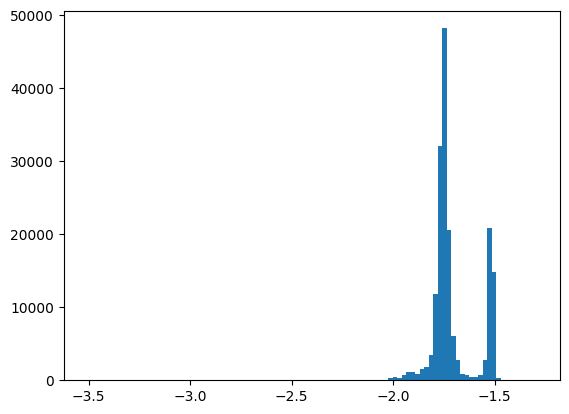

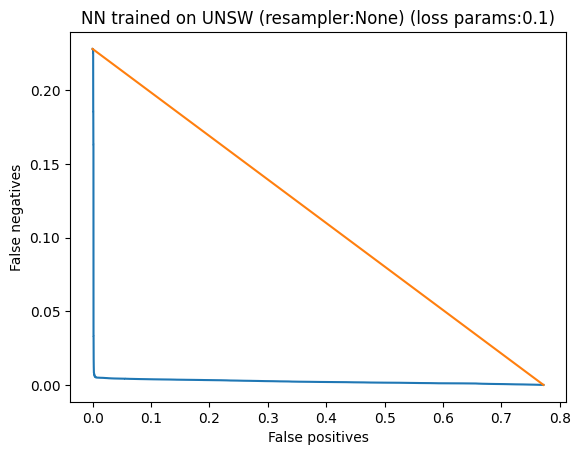

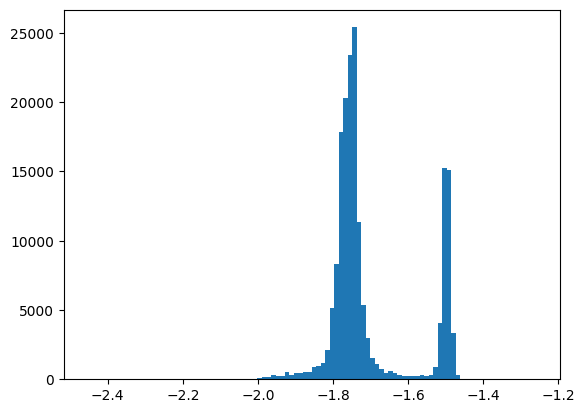

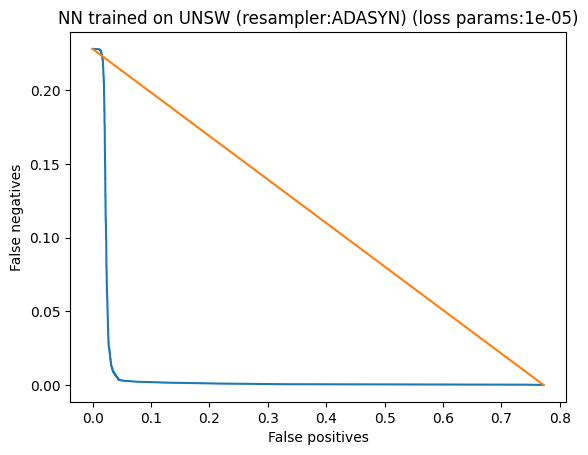

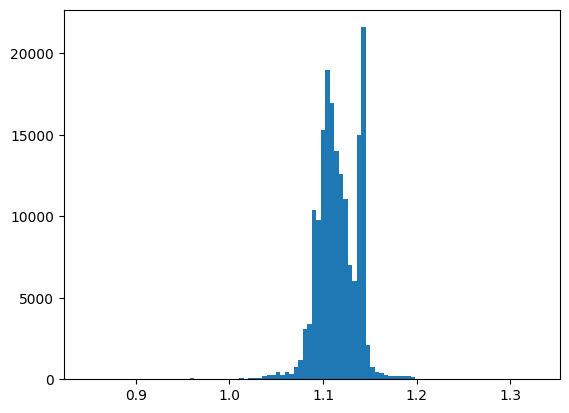

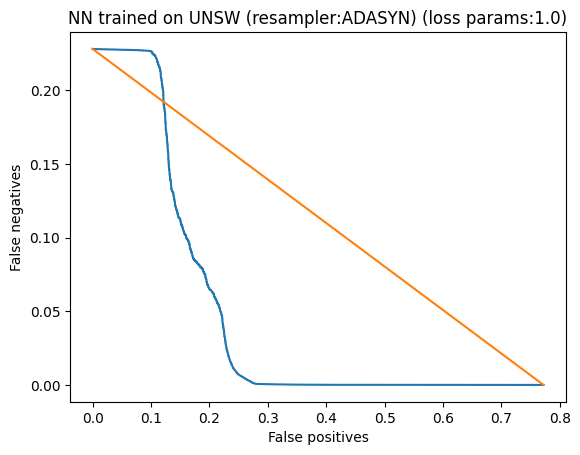

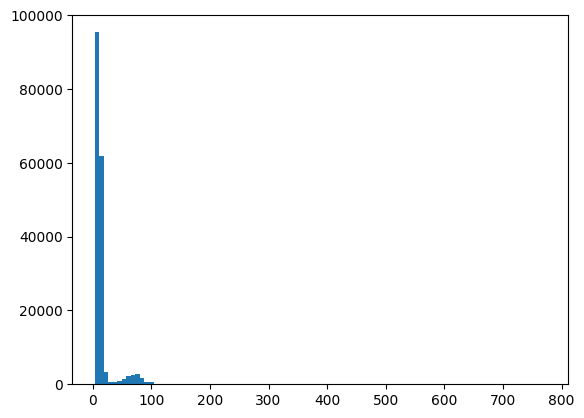

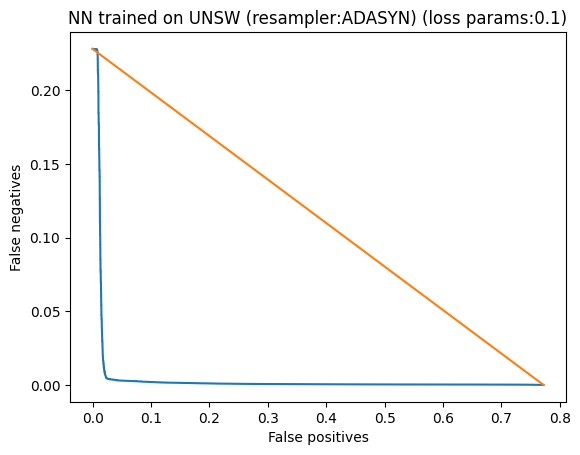

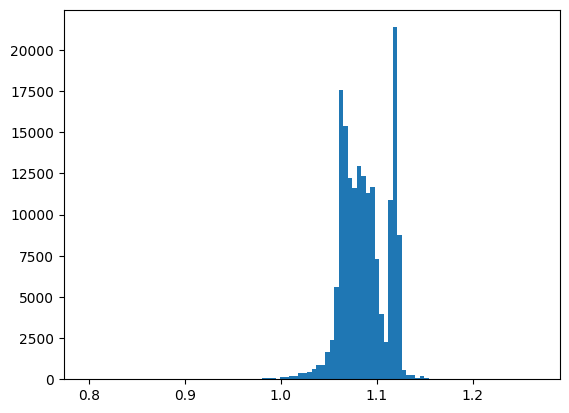

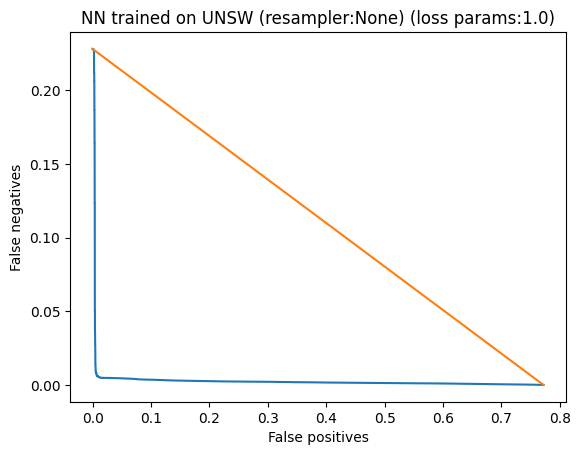

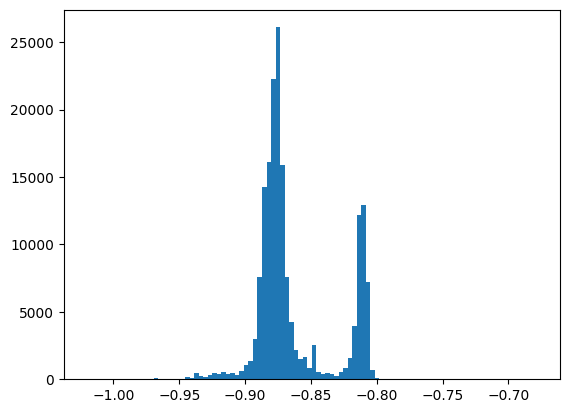

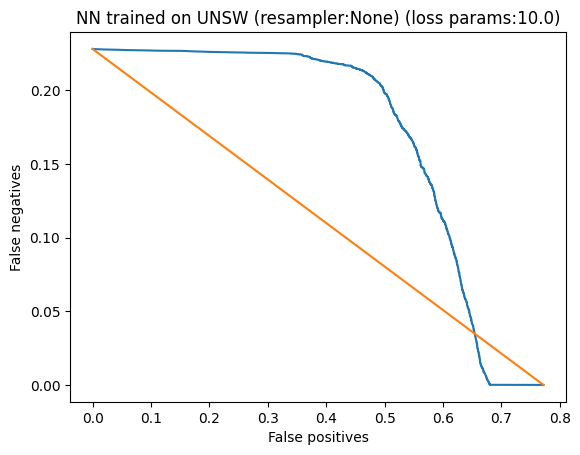

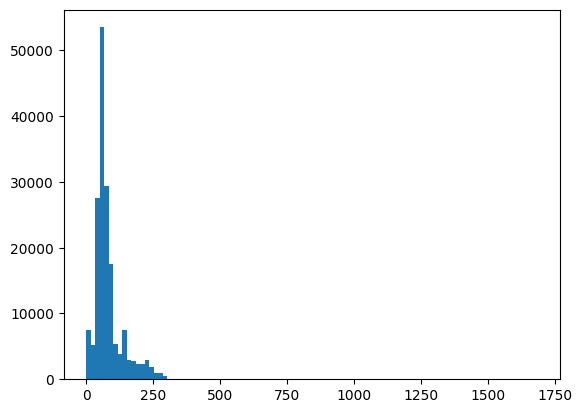

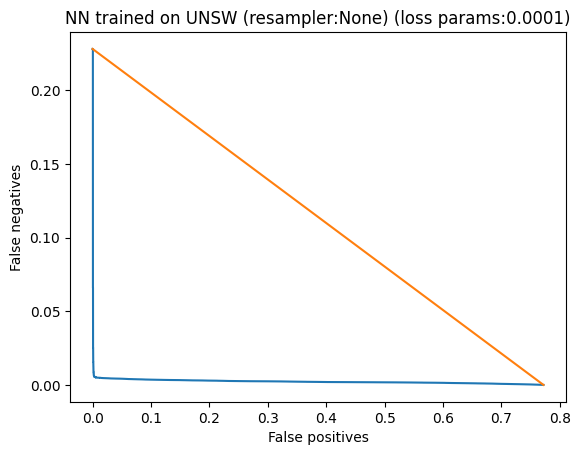

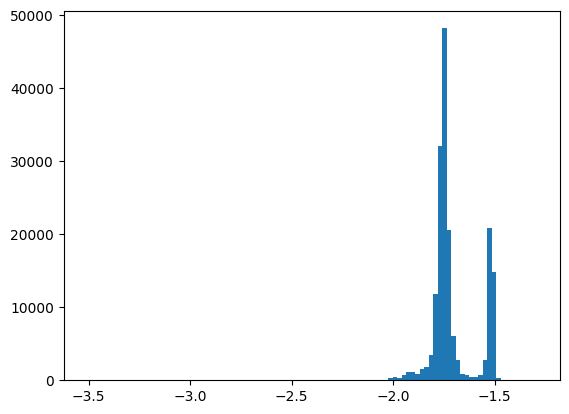

In [20]:
from cal.jal import make_fp_fn_perturbed_bce
nn_ab=NNPL(loss=make_fp_fn_perturbed_bce,**generic)
ab=[(i,j) for i in ([0]+[10**(-k) for k in range(7)]) for j in ([0]+[10**(2-k) for k in range(7)])]
for p in ab:
  nn_ab.fit(loss_param=p)
nn_g.report(rs_vs_raw=True,topk=3,plot_res=True)

Resampling data with method NearMiss ...
NearMiss doesn't take a random seed...
Resampling took 7.900531396997394 seconds
Completed 100 epochs in 5.890391942004499 seconds
Getting fp-fn characteristic
Resampling data with method SMOTEENN ...
Resampling took 109.39694948599936 seconds
Completed 100 epochs in 18.403465303999837 seconds
Getting fp-fn characteristic
Resampling data with method ADASYN ...
Resampling took 12.566889452995383 seconds
Completed 100 epochs in 18.785729731003812 seconds
Getting fp-fn characteristic
Resampling data with method SMOTE ...
Resampling took 2.512730432994431 seconds
Completed 100 epochs in 18.679686243995093 seconds
Getting fp-fn characteristic
Resampling data with method SMOTETomek ...
Resampling took 109.43117127000005 seconds
Completed 100 epochs in 18.82228214800125 seconds
Getting fp-fn characteristic
Resampling took 0 seconds
Completed 100 epochs in 11.182609558003605 seconds
Getting fp-fn characteristic
Resampling took 7.900531396997394 seconds


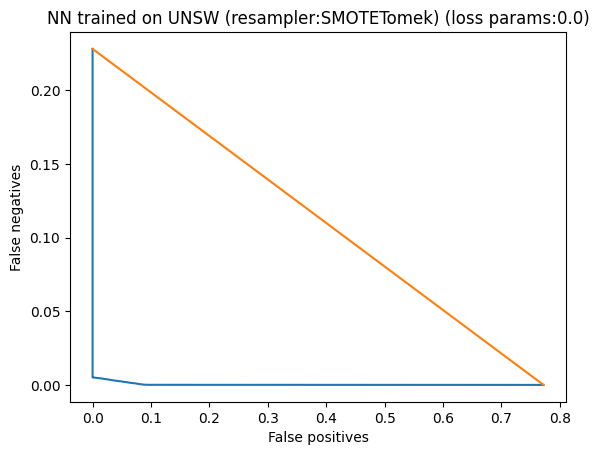

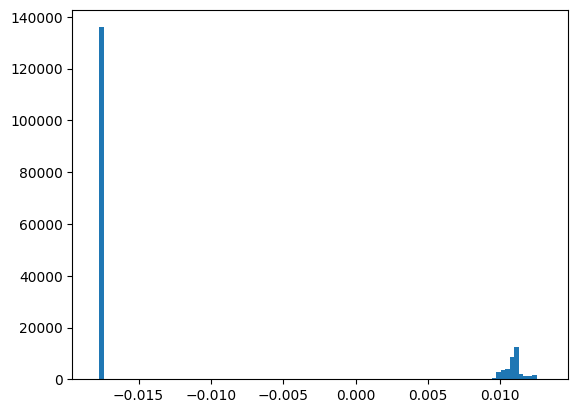

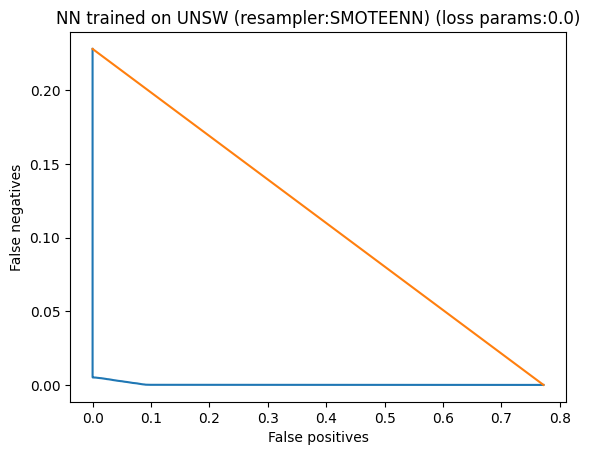

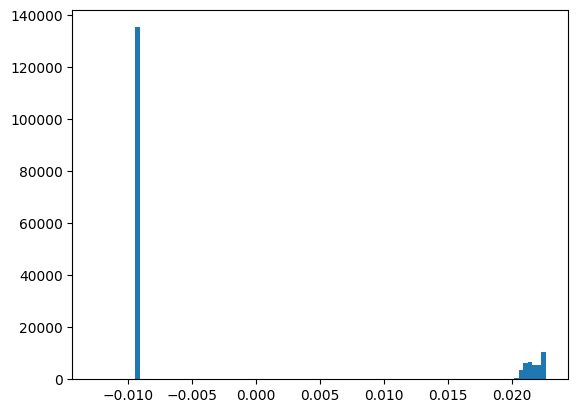

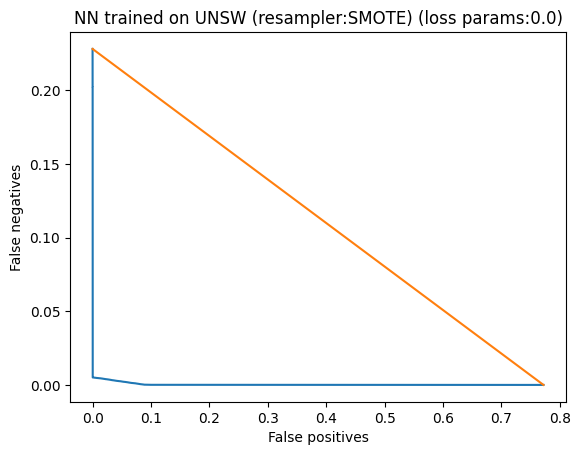

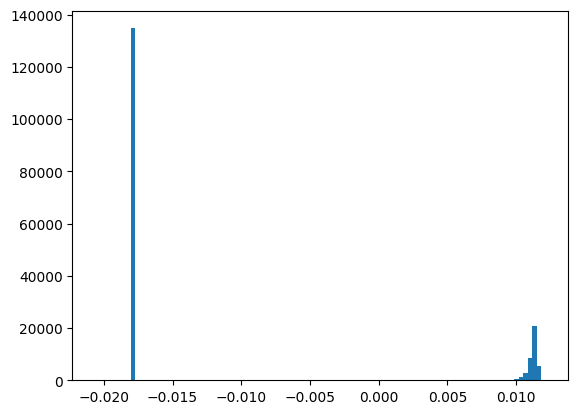

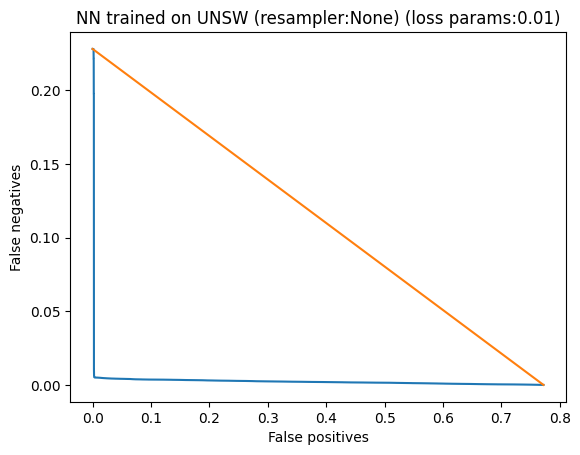

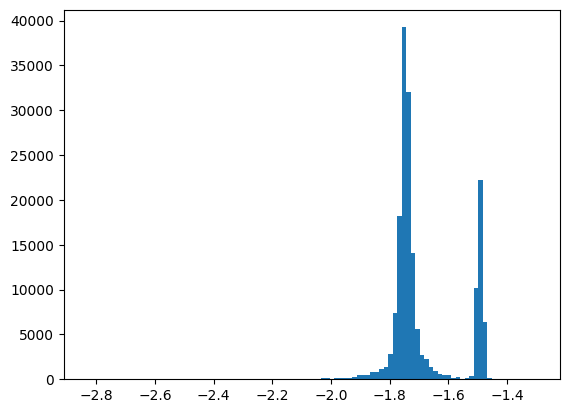

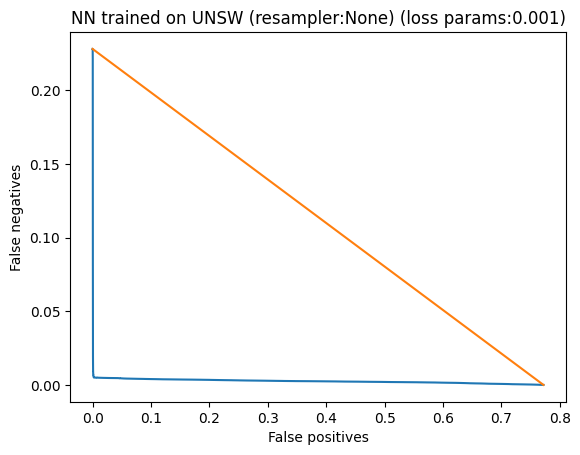

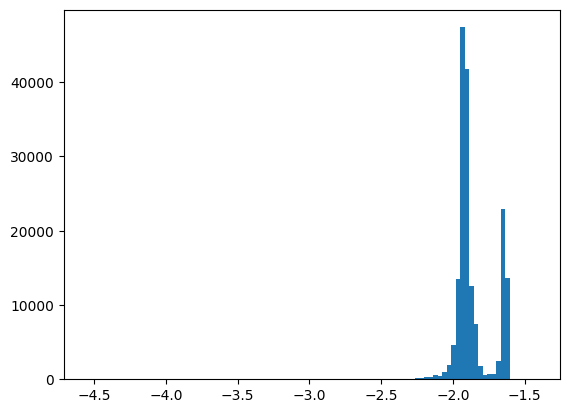

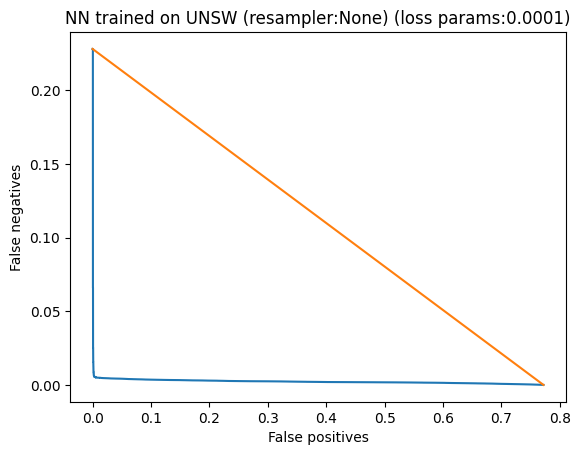

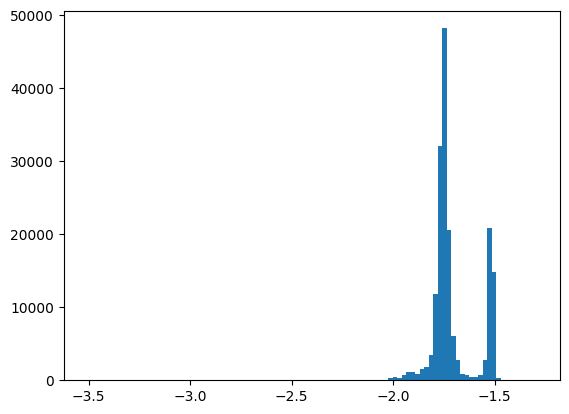

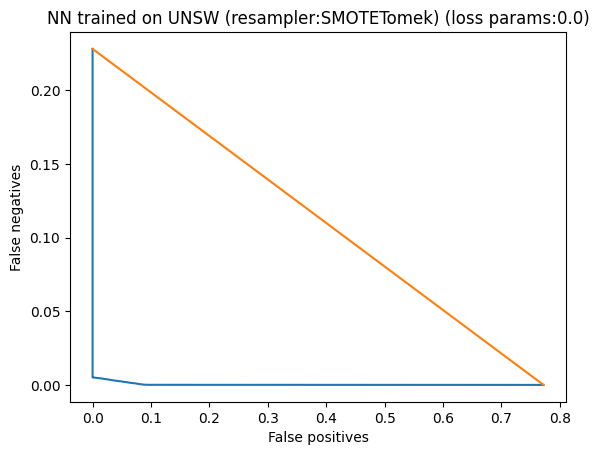

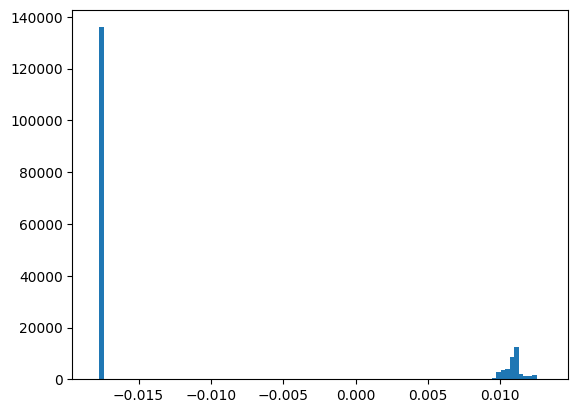

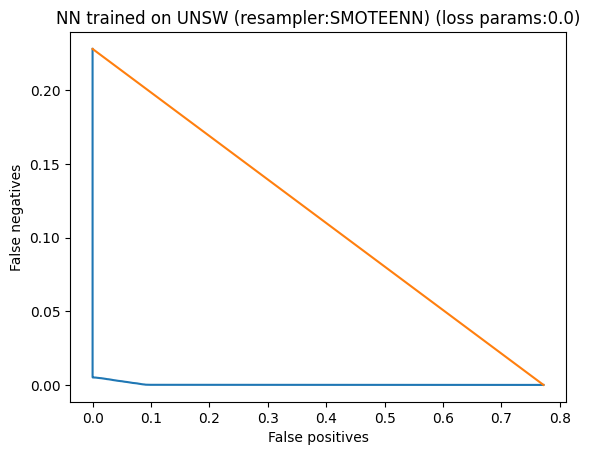

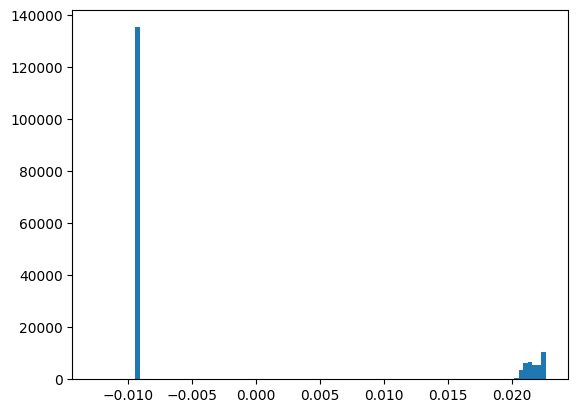

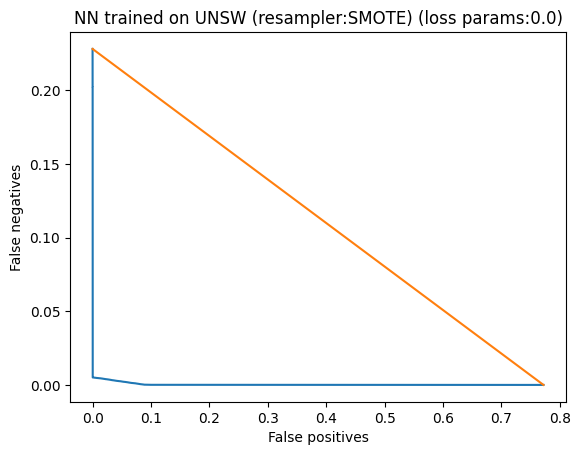

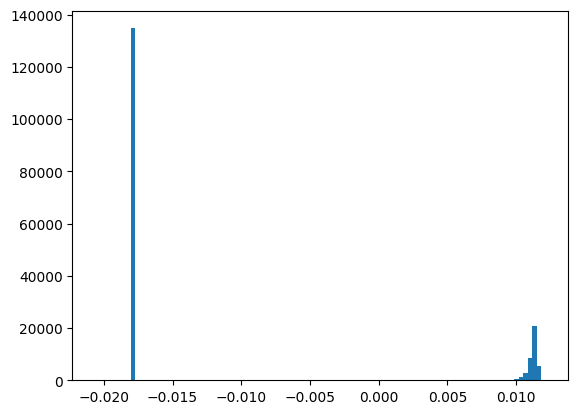

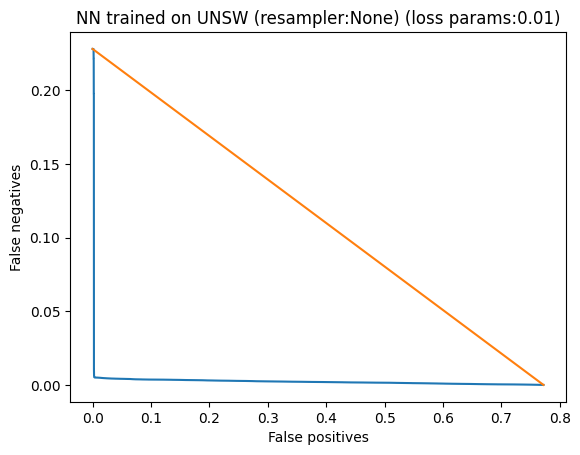

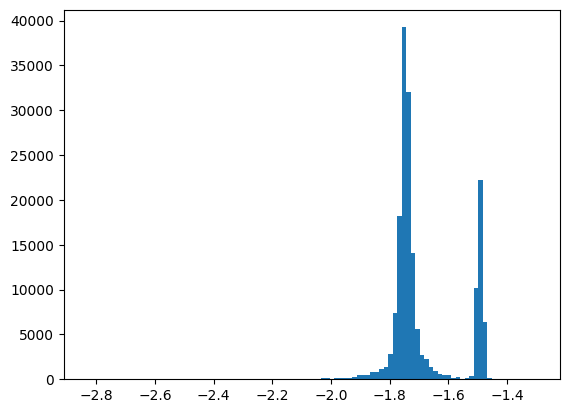

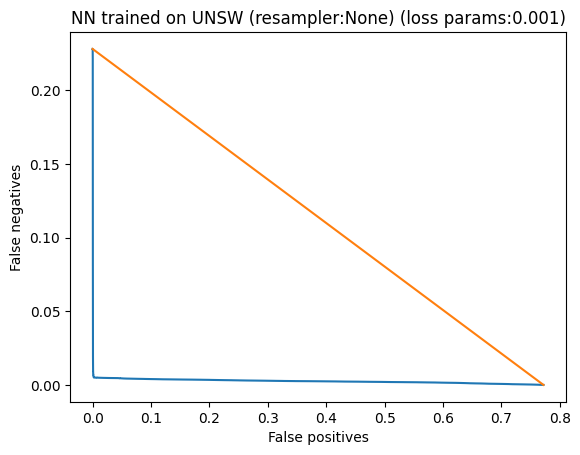

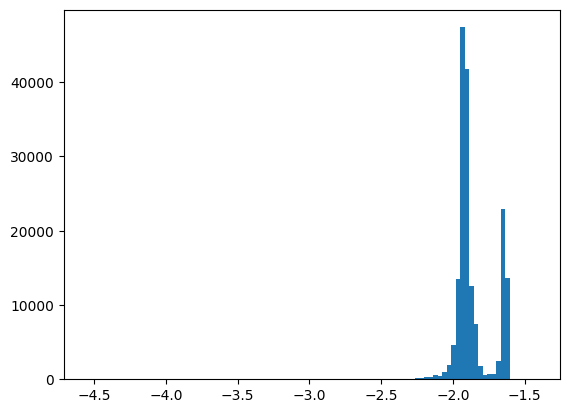

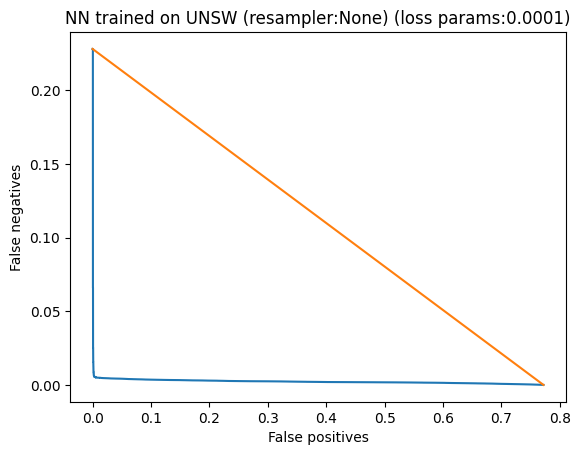

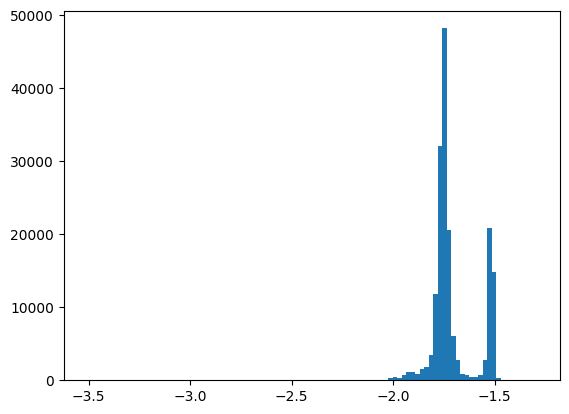

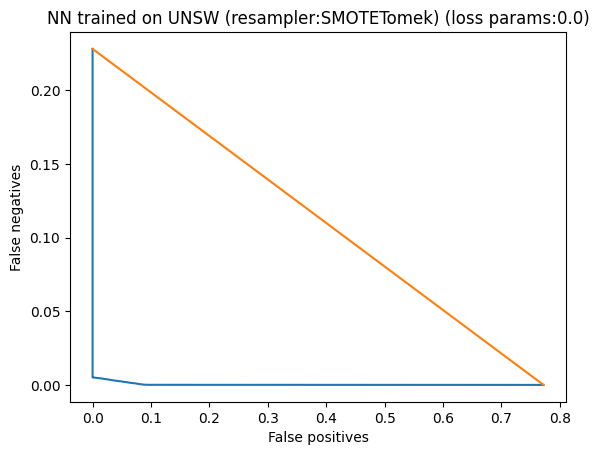

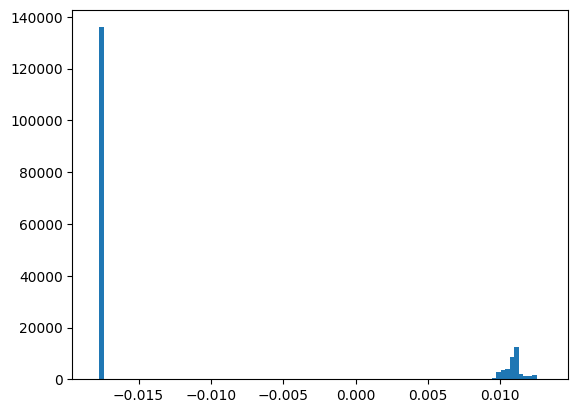

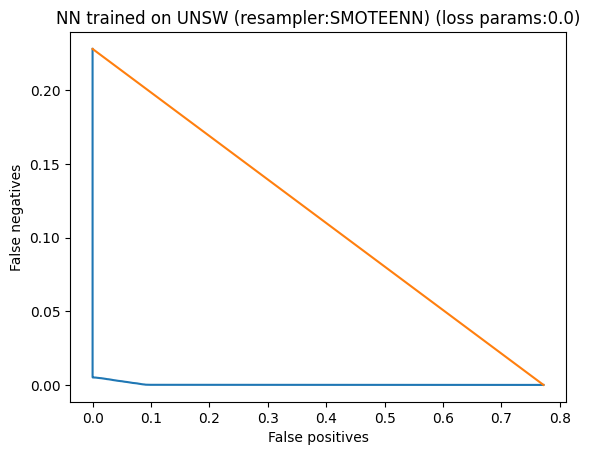

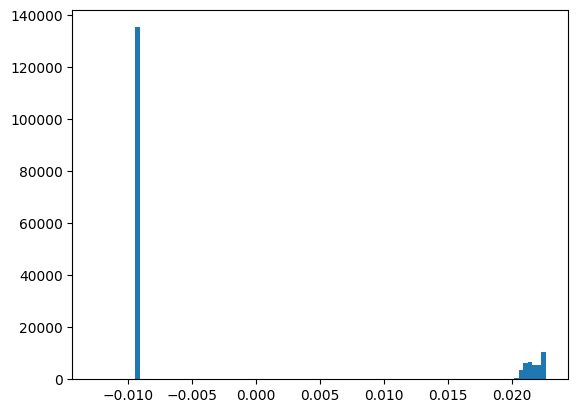

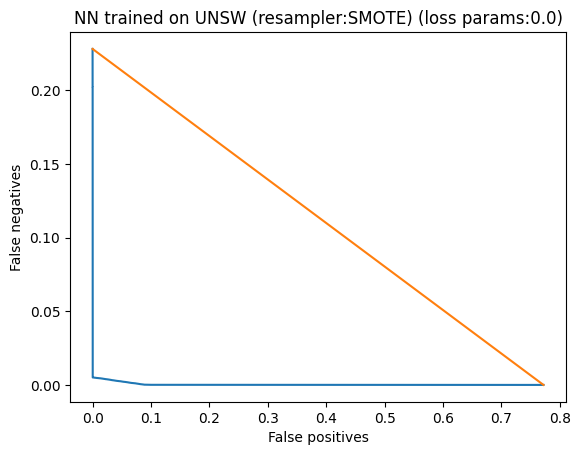

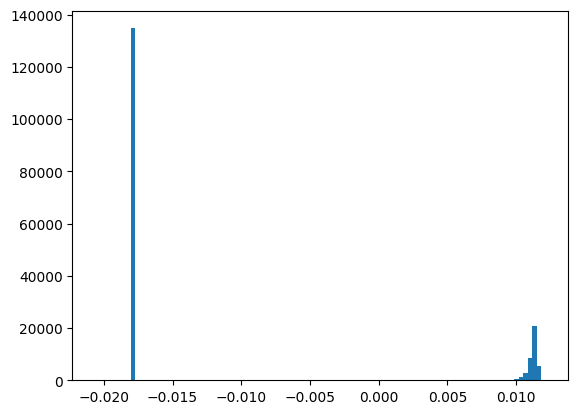

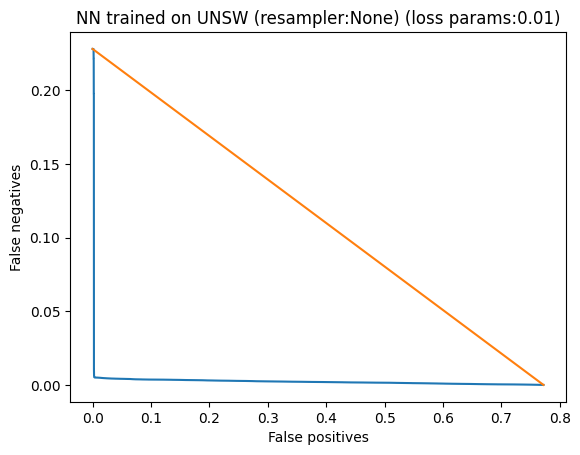

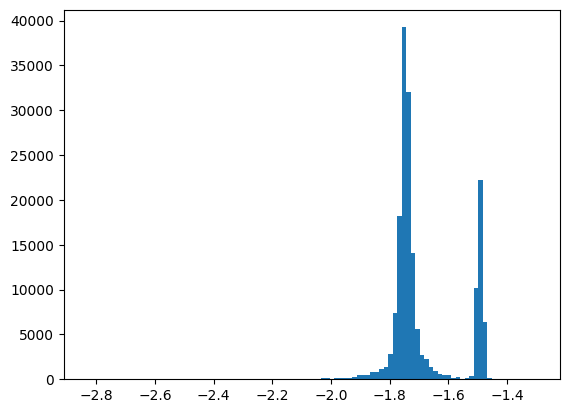

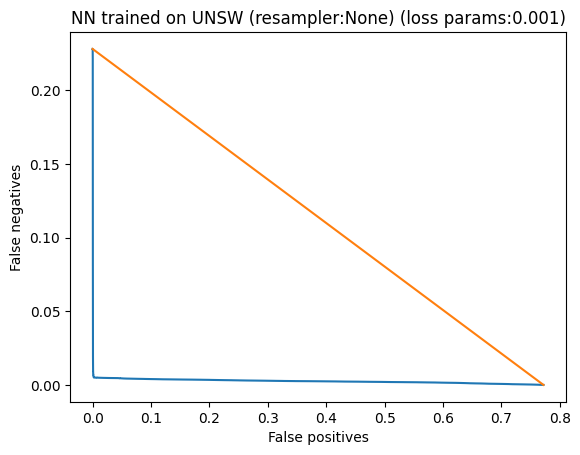

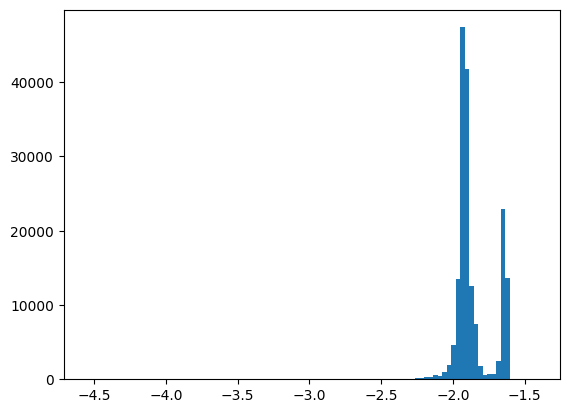

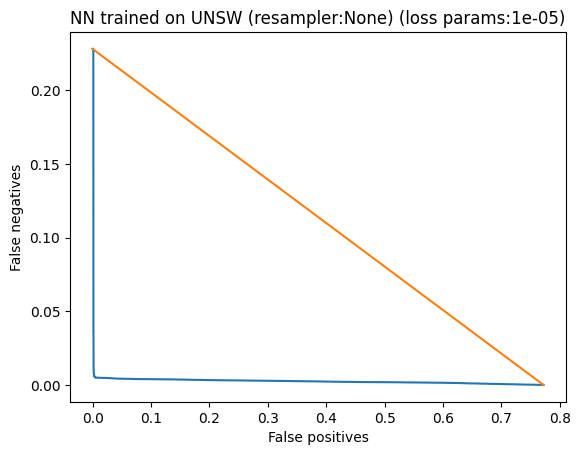

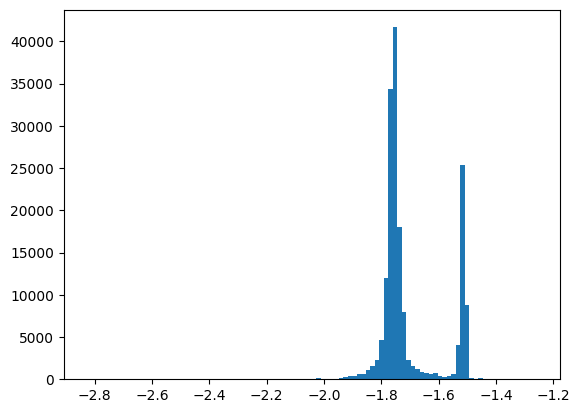

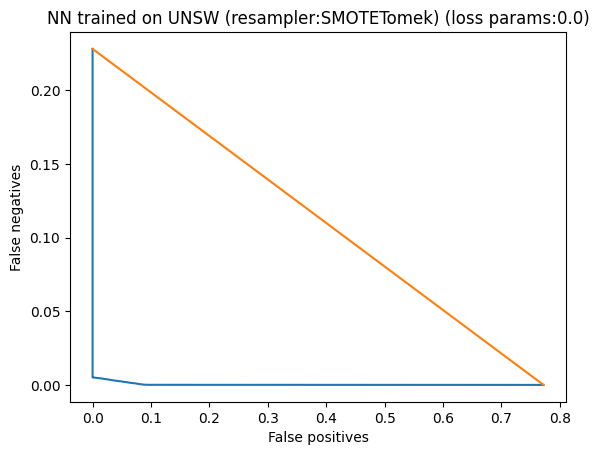

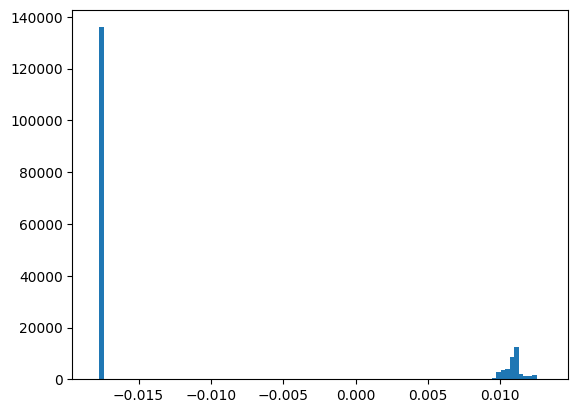

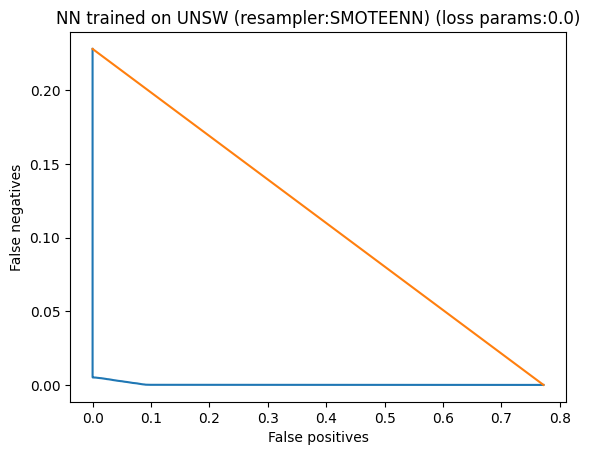

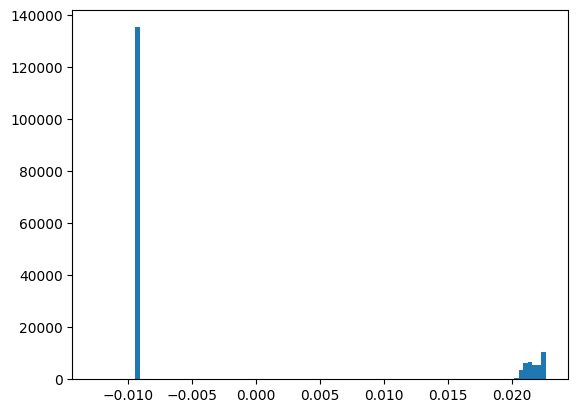

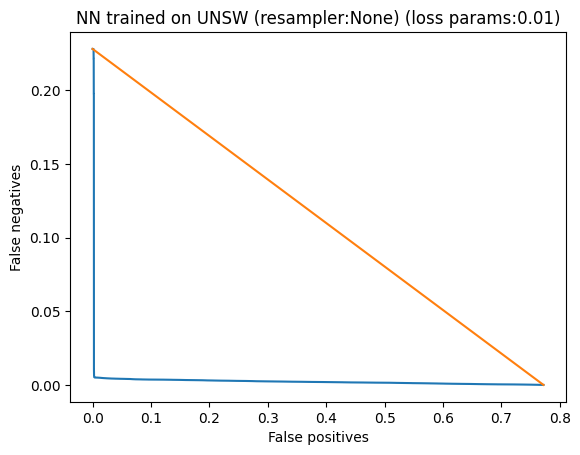

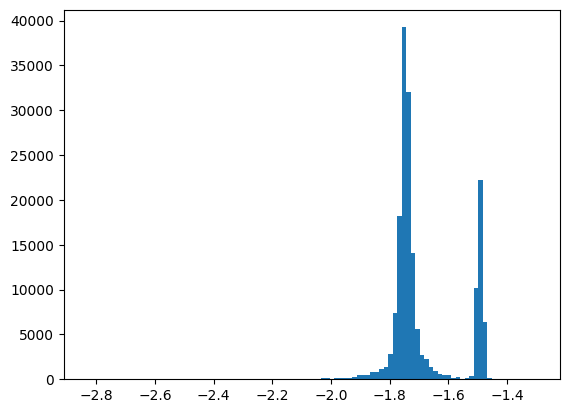

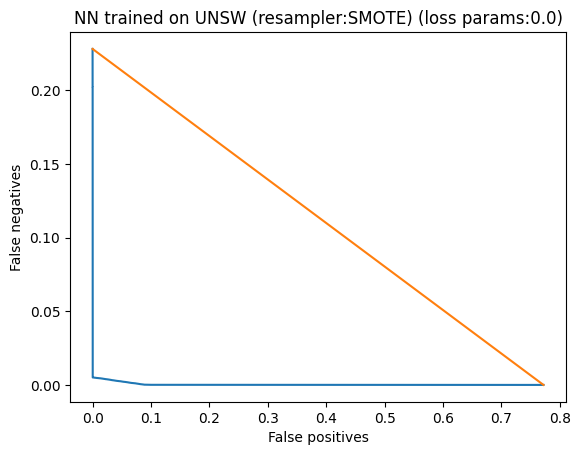

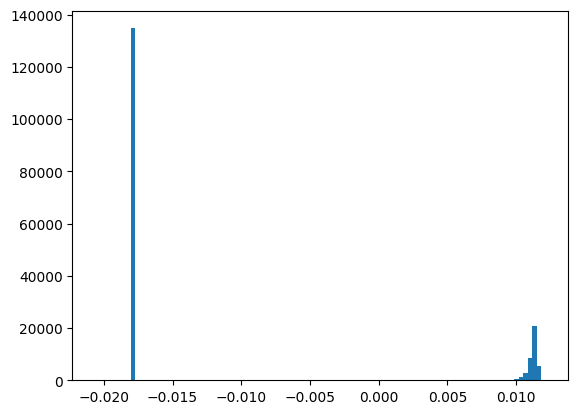

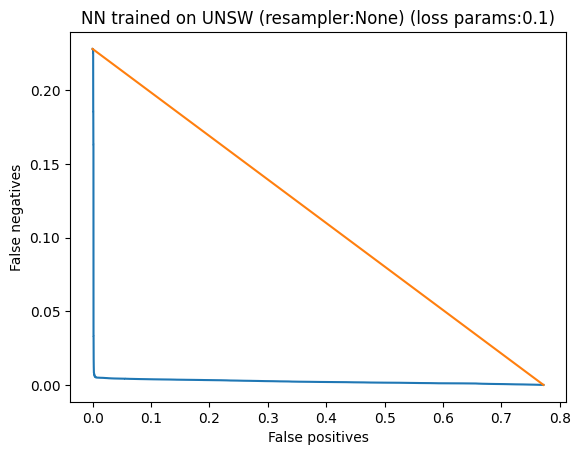

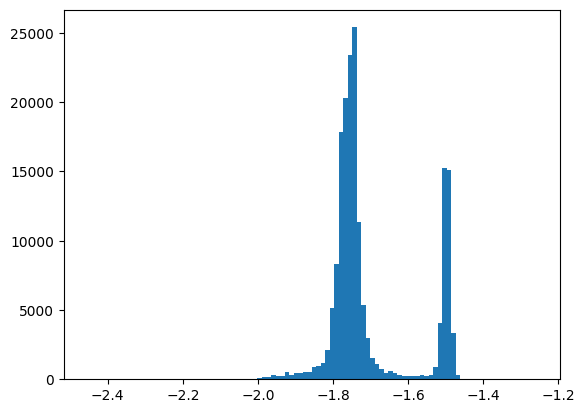

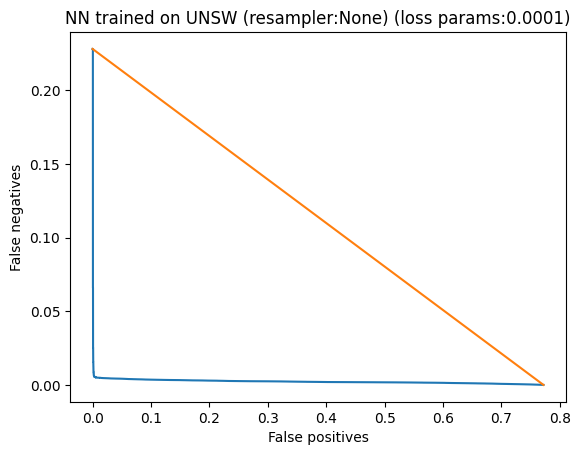

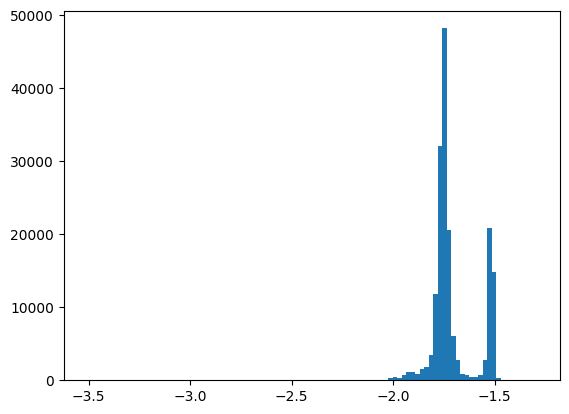

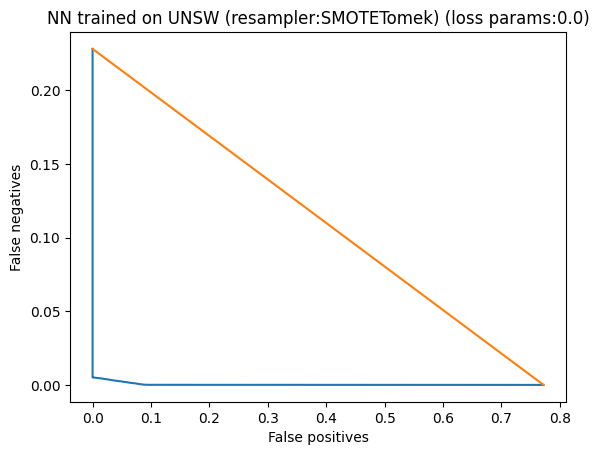

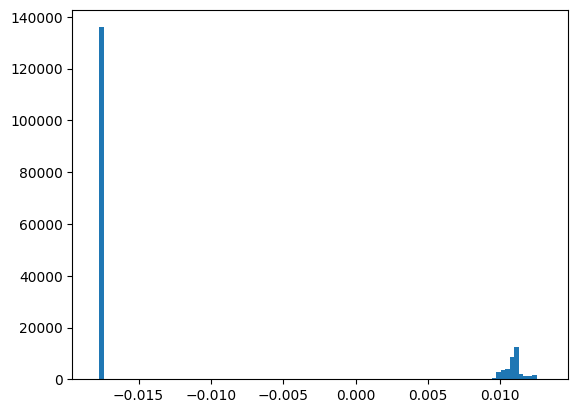

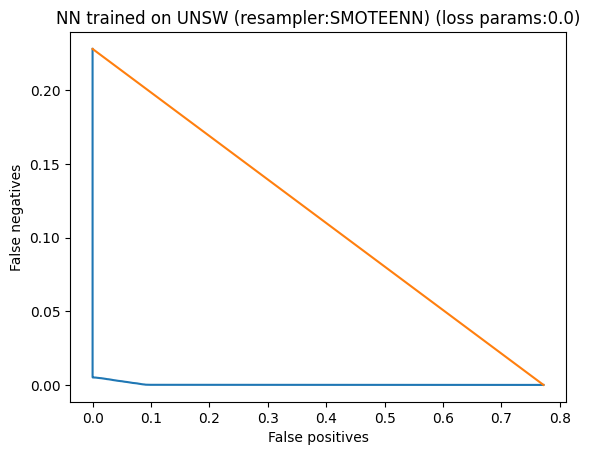

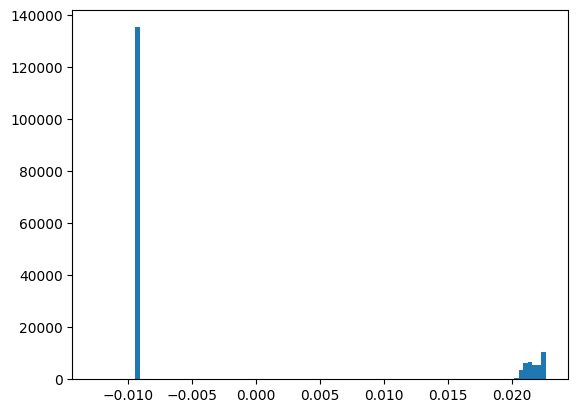

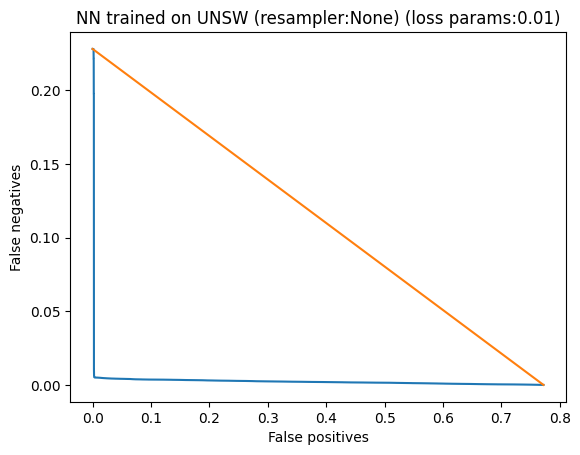

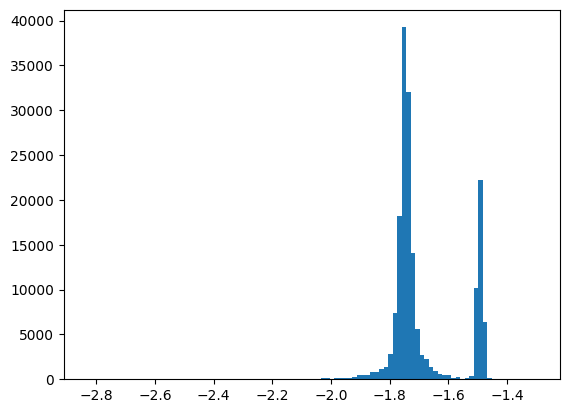

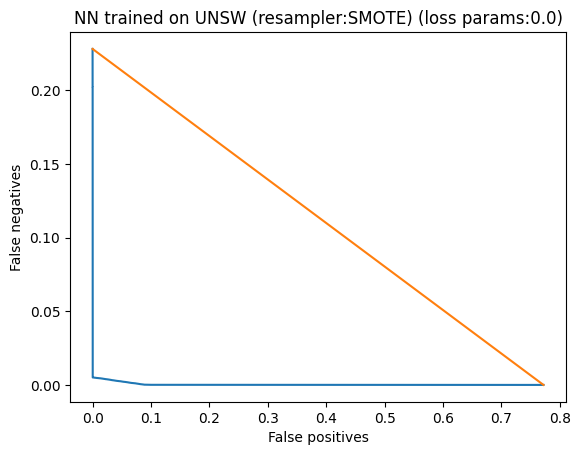

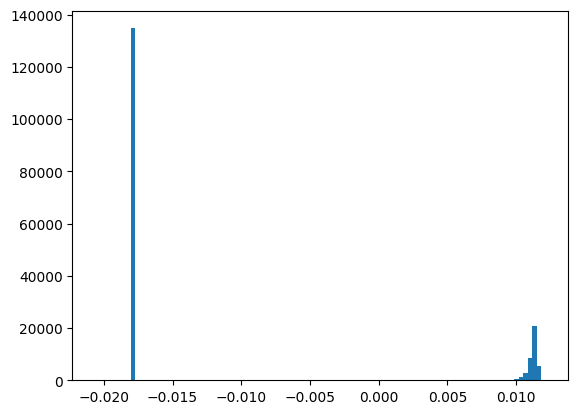

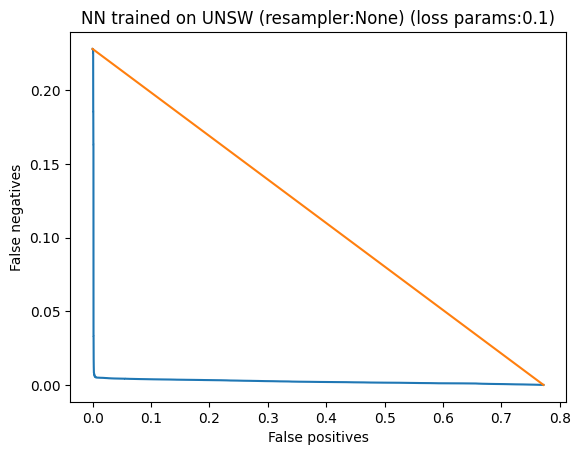

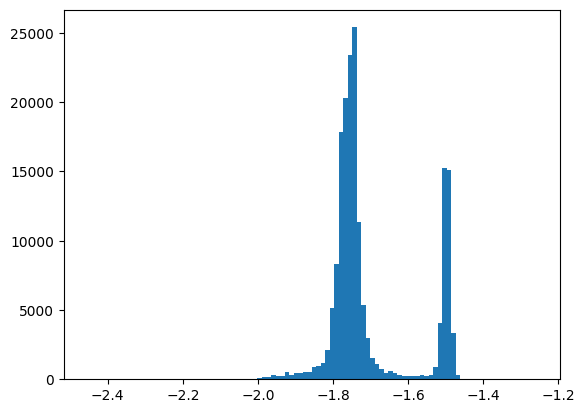

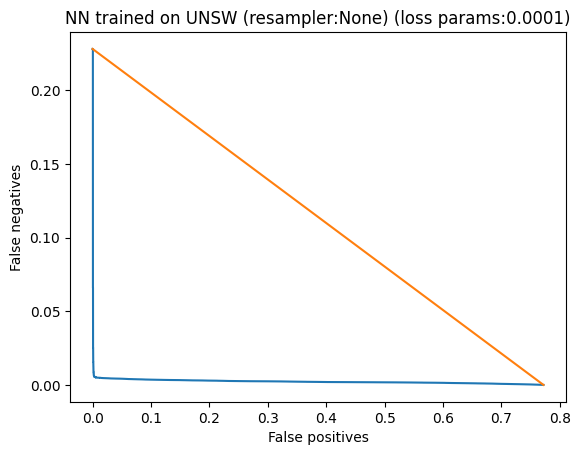

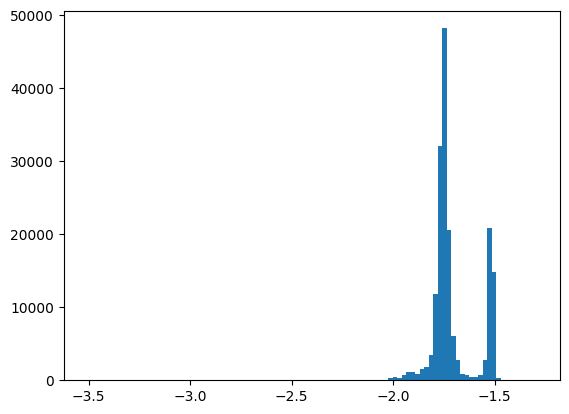

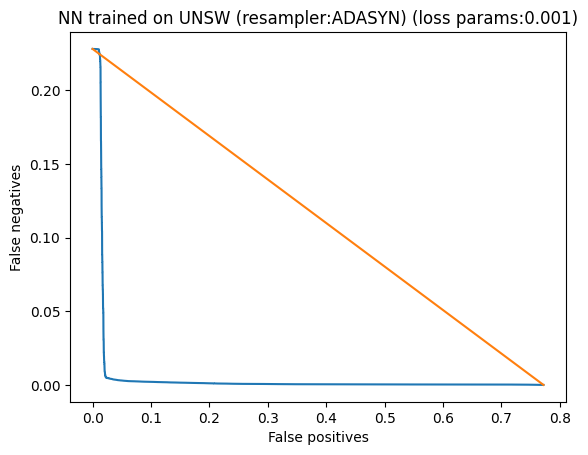

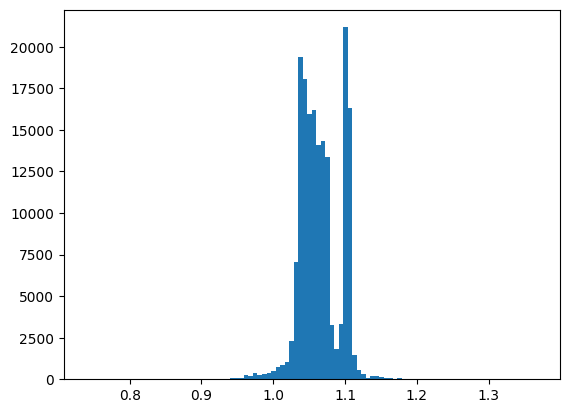

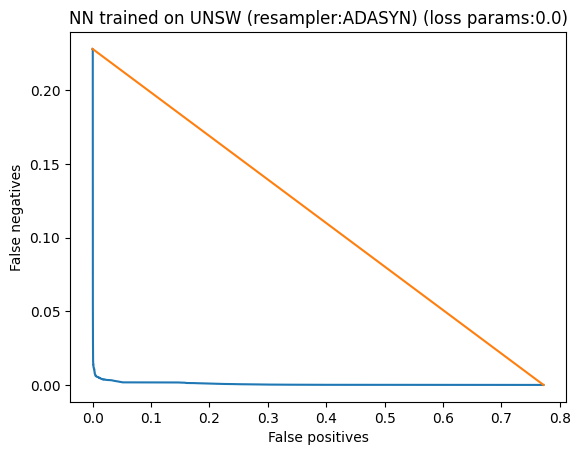

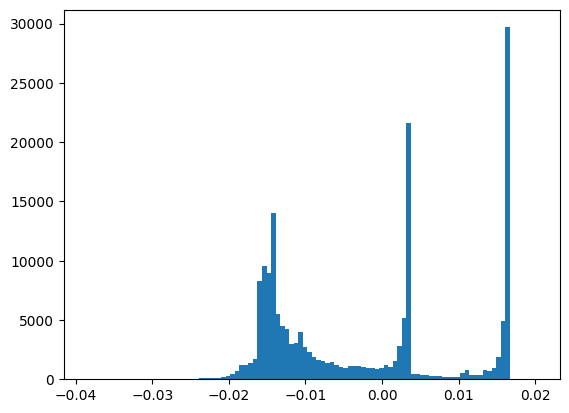

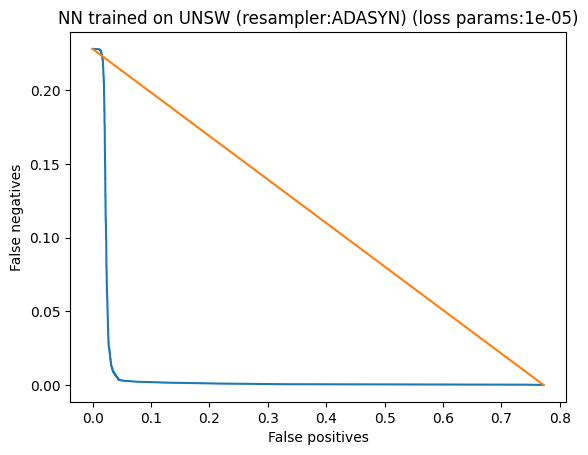

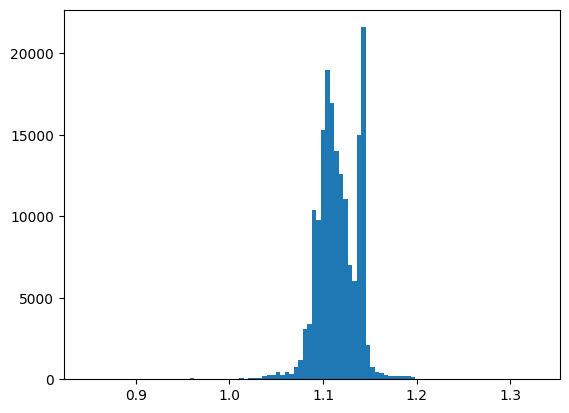

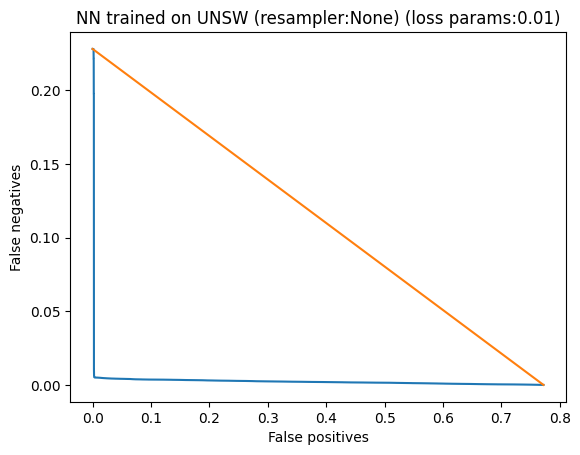

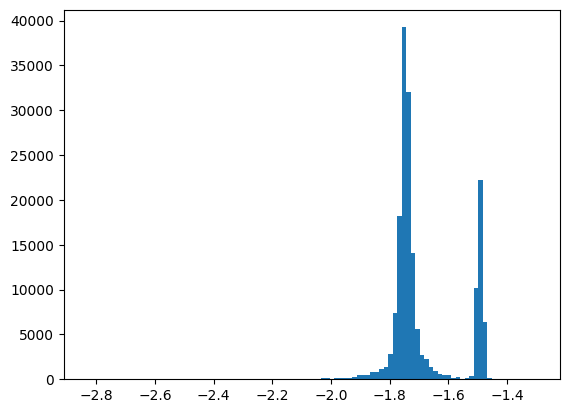

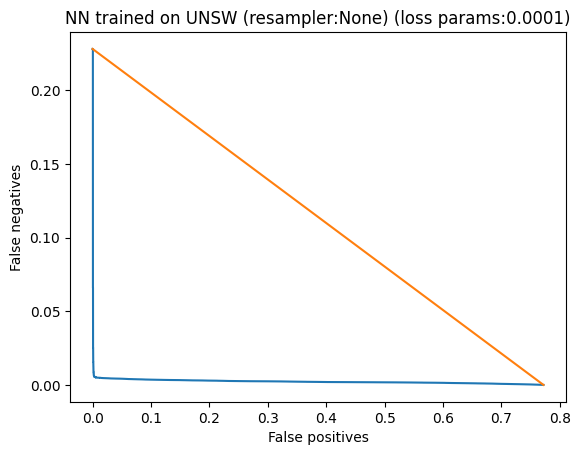

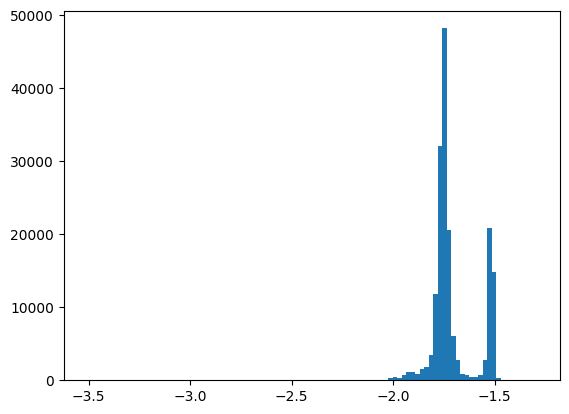

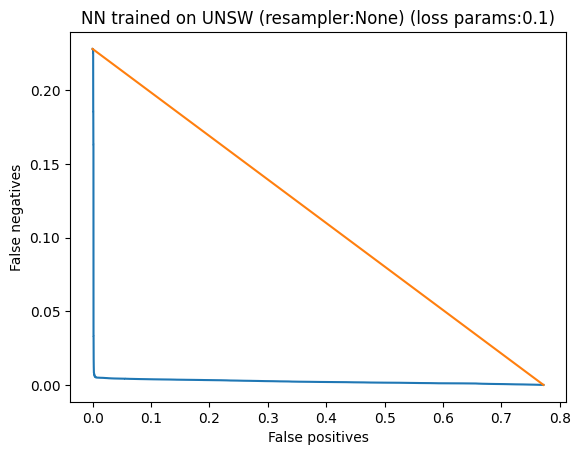

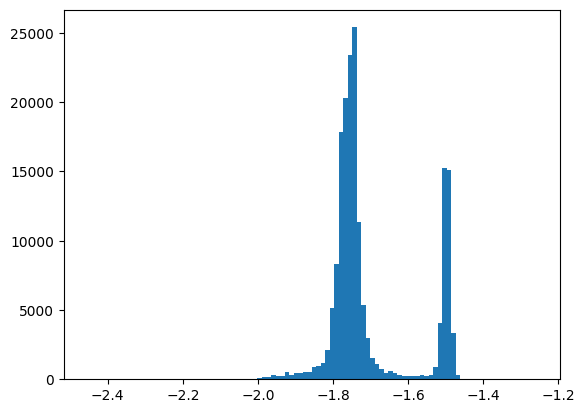

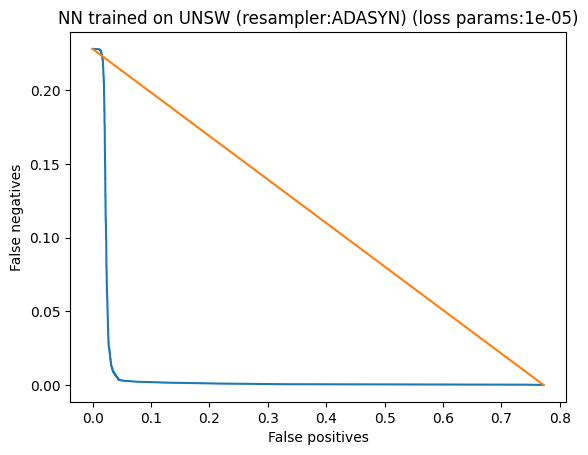

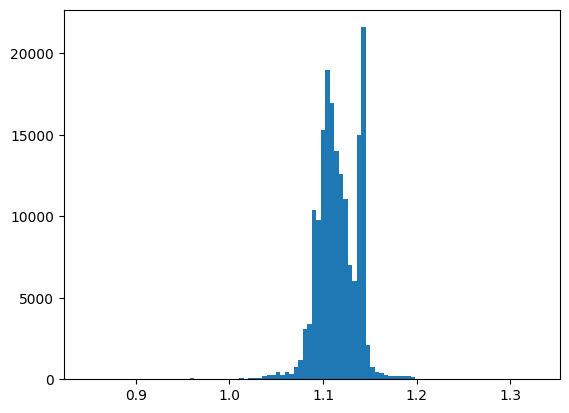

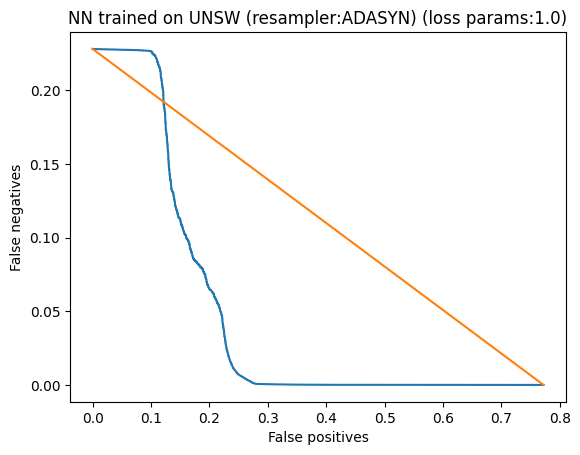

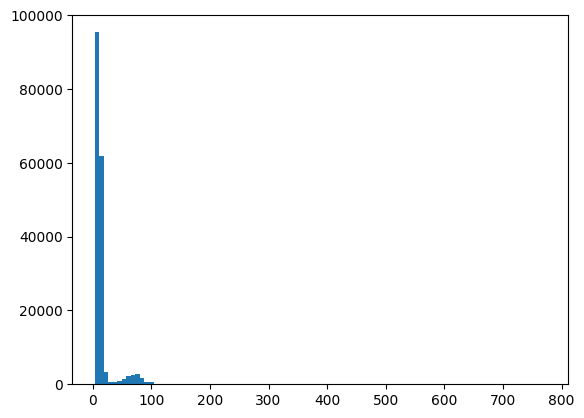

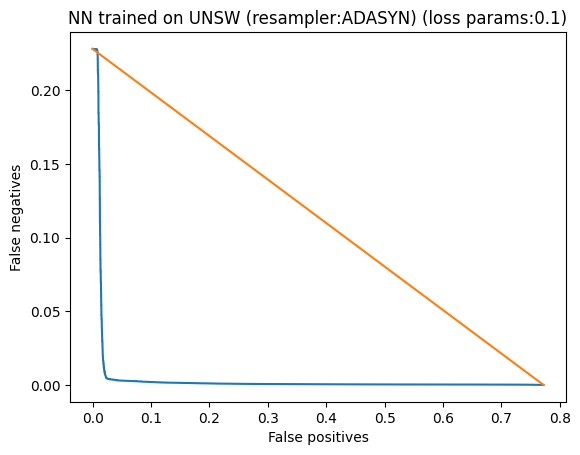

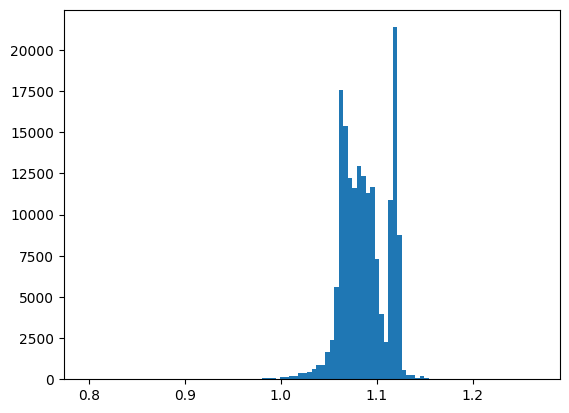

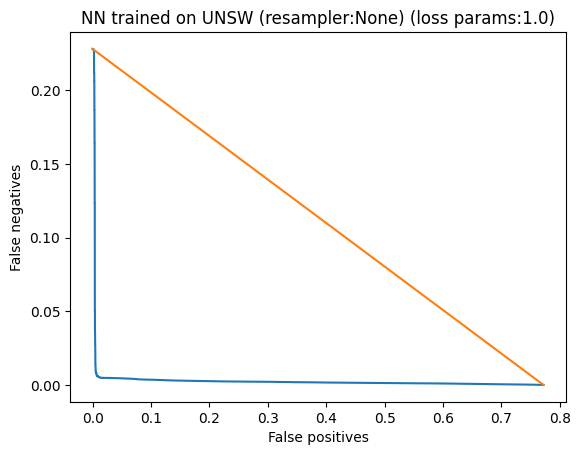

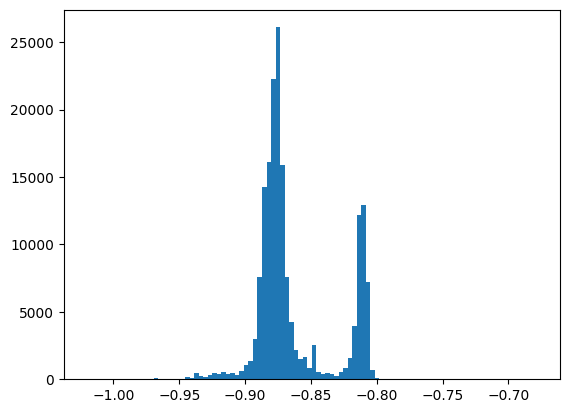

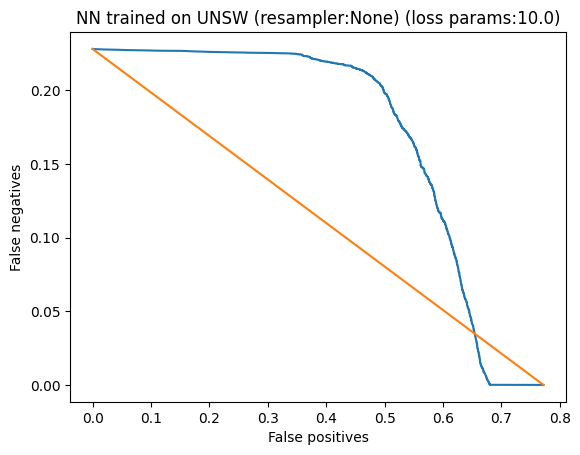

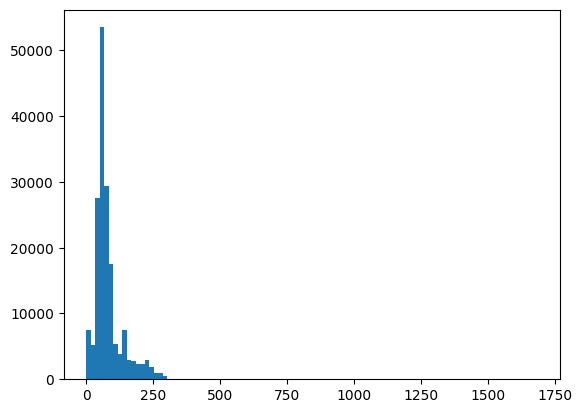

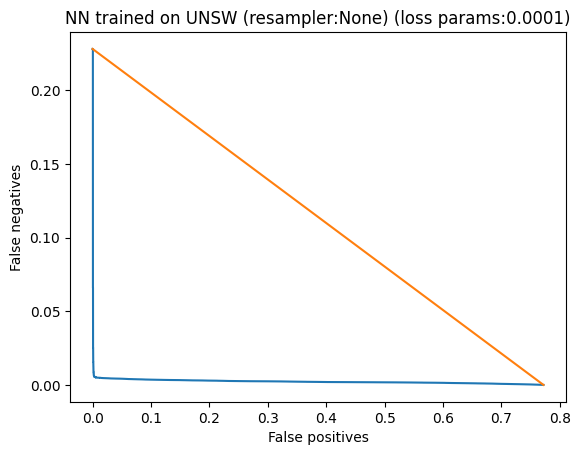

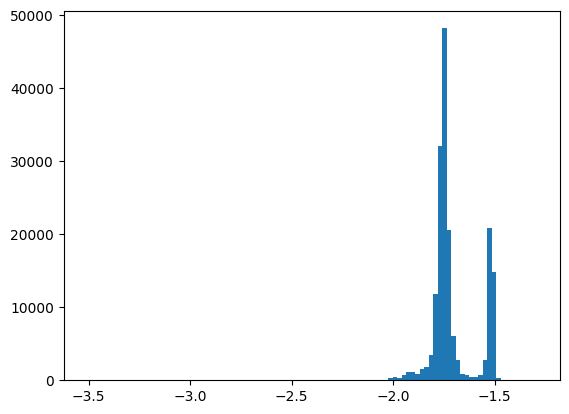

In [21]:
from cal.jal import make_fp_fn_perturbed_bce
nn_ab=NNPL(loss=make_fp_fn_perturbed_bce,**generic)
ab=[(i,j) for i in ([0]+[10**(-k) for k in range(7)]) for j in ([0]+[10**(2-k) for k in range(7)])]
for p in ab:
  for rs in resamplers_list:
    nn_ab.fit(loss_param=p,rs=rs)
nn_g.report(rs_vs_raw=True,topk=3,plot_res=True)